# Module 6: CFA
# Investment Use Case: Avoiding Biases in Investment models using Machine Learning 
# =========================================================

Many statistical, behavioral and structural biases can distort the high risk area of investment model development. Investment models are responsible for selecting or recommending individual names or securities for investments, and so the outcomes have a potentially very high impact on stake holders. Investment models are broadly separated into stock selection and portfolio construction models. Stock selection models, because of their granular focus, generally greater data needs and higher complexity, are typically most exposed to biases in model development. Whereas portfolio construction models - a challenging and complex area of research for sure - tend to be more generically based on diversifying return characteristics using, typically covariance or clustering based optimizations. 
The possibility of applying machine learning (ML) tools applied to stock selection, has the potential to avoid many traditional quant investing biases, but also comes with the significant risk of increasing model risk.
This use case focuses on mitigating biases in stock selection models.

This use case develops three stock selection models in a global equities universe. 
- **Traditional quant:** First, we examine the risk of biases of traditional quant models, based on a linear factor approach, identifying problematic assumptions and violations.
- **Hybrid Machine Learning/quant:** Second, we look to improve this traditional quant approach by bolting on a machine learning elements: traditional quant+ML. We will see that this presents additional risks and biases, as we attempt to improve a traditional quant model using a neural net.
- **Interpretable machine learning stock selection**: Third, we examine a purpose designed ML approach, designed to avoid or address many of the possible biases in both traditional quant and traditional quant+ML. 

### References
[1] Philps, D., Tilles, D., & Law, T. (2021). Interpretable, Transparent, and Auditable Machine Learning: An Alternative to Factor Investing. The Journal of Financial Data Science, 3(4), 84-100
 https://jfds.pm-research.com/content/early/2021/09/22/jfds.2021.1.077
 
[2] Fama, E.F. and French, K.R., 2015. A five-factor asset pricing model. Journal of financial economics, 116(1), pp.1-22.

[3] Fabozzi, F. J., Focardi, S. M., & Kolm, P. N. (2010). Quantitative equity investing: Techniques and strategies. John Wiley & Sons.

[4] Israel, R., & Ross, A. (2017). Measuring factor exposures: Uses and abuses. The Journal of Alternative Investments, 20(1), 10-25.

[5] Levin A. (1995). Stock Selection via Nonlinear Multi-Factor Models. Advances in Neural Information Processing Systems, 8.
  https://proceedings.neurips.cc/paper/1995/file/d6ef5f7fa914c19931a55bb262ec879c-Paper.pdf 


### Code Repositories
https://github.com/danphilps/Investment-SAI






Get key packages, download data and get in good shape.

In [1]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# package for navigating the operating system
import os

# Progress bar
from tqdm.notebook import tqdm

# Pretty dataframe printing for this notebook
from IPython.display import display

# Suppress warnings for demonstration purposes...
import warnings

# Type checking
import numbers

# are we running in colab?
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

## Github Repo
Many of the functions we use in this notebook are wrapped up in functional classes on the in the Investment-SAI repository, and some in the FinGov repository. For students with coding background and the interest, we encourage you to review these classes and functions.

In [2]:
# Dependency: We may have to install SHAP, an explainable AI (XAI) package onto your machine (or your Google Colab session if you are running this notebook in Colabl)
# We may need to install shap..
if IN_COLAB == True:
  !pip install shap
else:
  %pip install shap

import shap

# Clone the FinGov repo which has key utility functions for this notebook
if os.path.exists('FinGov') == False:
  !git clone https://github.com/danphilps/FinGov

# Now import the objects from the repo
os.chdir('FinGov')
from GovernanceUtils import GovernanceUtils
from FairnessUtils import FairnessUtils
import CFACreditUseCaseUtils

Note: you may need to restart the kernel to use updated packages.


Install SAI and otehr packages we will need

In [3]:
# We may need to install shap..
if IN_COLAB == True:
  !pip install investsai -q
else:
  %pip install investsai -q

# May need to upgrade ipykernel to avoid deprication warnings
if IN_COLAB == True:
  !pip install --upgrade ipykernel
else:
  %pip install --upgrade ipykernel

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Clone the FinGov repo which has key utility functions for this notebook
with warnings.catch_warnings(): # Turn warnings off for this use case
    os.chdir('..')
    if os.path.exists('InvestmentToolkit') == False:
      !git clone https://github.com/danphilps/InvestmentToolkit

    # Now import the objects from the repo
    os.chdir('InvestmentToolkit')

    # Import the functional classes we need...
    warnings.simplefilter("ignore")
    from InvestmentToolkit import SimulationUtils
    from InvestmentToolkit import RobustInvestmentUtils
    from InvestmentToolkit import LinearFactorInvesting
    from InvestmentToolkit import NonLinearFactorInvesting
    from InvestmentToolkit import SAIInvesting

# Stage1: Business Case

The business case for investment models tends to be very clear, but it is surprising how few analysts spend time defining the "ground truth" for their models, other than the obvious objective of selecting "higher alpha" securities. "Ground truthing" in this context could be described as getting the decision **right for the right reasons**, which a positive alpha end point does not necessarily define. For instance a defensive strategy might benefit from a stock that ultimately generates positive alpha, but if the downside characteristics of that stock in the shorter run are poor, it could prove to be a bad investment. In this case the ground truth might simply be, **positive alpha AND defensive characteristics**. Once the ground truth has been defined,hypotheses are then needed which can be tested, and an experimental setup is required to test them.





# Stage2: Data

We will use a subset of a US small cap equities universe, defined as US stocks with a market cap between aproximately \\$ 150m and \\$ 3bn. 
First we pull in the data we need, wrangle it, examine it and prepare it.


## Stage2a. Load Data
Step into the data directory...

In [5]:

if IN_COLAB == True:
  from google.colab import drive
  import os
  drv = drive.mount('/content/gdrive')
  root_path = 'gdrive/My Drive/your_project_folder/'

  os.listdir('/content/gdrive/MyDrive/CFAI')
  os.chdir('/content/gdrive/MyDrive/CFAI')
else:
  os.chdir('..')
  os.chdir('data')


Get returns and fundamentals for our universe and load into DataFrames

In [6]:
# Extract security level returns - Monthly frequency
df_raw_sec_rets = pd.read_csv('TR_US_SMID.csv')
# Extract security level fundamentals - Monthly frequency
df_raw_sec_ff = pd.read_csv('FF_US_SMID.csv', encoding = "ISO-8859-1")

In [7]:
df_raw_sec_rets

,TICKER,FSYM_ID,DATE,CURRENCY,PRICE_DATE,MTD_RETURN_LOCAL,MTD_RETURN_USD,Unnamed: 7
0,AAALF-US,QQ4Y96-R,11/30/2012,USD,11/28/2012,NaN,NaN,55
1,AAALF-US,QQ4Y96-R,12/31/2012,USD,12/19/2012,-1.4953,-1.4953,55
2,AAALF-US,QQ4Y96-R,01/31/2013,USD,01/31/2013,14.2789,14.2789,55
3,AAALF-US,QQ4Y96-R,02/28/2013,USD,02/19/2013,NaN,NaN,55
4,AAALF-US,QQ4Y96-R,03/31/2013,USD,03/27/2013,-10.5438,-10.5438,55
...,...,...,...,...,...,...,...,...
955372,ZZLL-US,PHJKWQ-R,06/30/2022,USD,06/17/2022,5.2632,5.2632,10531
955373,ZZLL-US,PHJKWQ-R,07/31/2022,USD,07/20/2022,-12.6250,-12.6250,10531
955374,ZZLL-US,PHJKWQ-R,08/31/2022,USD,08/15/2022,28.7554,28.7554,10531
955375,ZZLL-US,PHJKWQ-R,09/30/2022,USD,09/29/2022,-4.4444,-4.4444,10531


### Selecting a subset of securities for this use-case

We select a subset of securities for this use-case to reduce processing time, and to provide a good illustration of the processes we are demonstrating. This is clearly exposed to biases in itself, but please experiment with the securities universe yourself and forgive us this expediency.


In [8]:
# load the subset of securities to use as an example...

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Use our pre-prepared securities list
# Note that for the purposes of this demonstration we are using preprepared securities list
# This is to reduce the processing time of the notebook, and to make the dataset less cumbersome
# **DO NOT USE THIS APPROACH IN YOUR OWN WORK**
# Set the use_stochastic variable below to True to observe how introducing these randomized elements impacts the outcomes. 
# Outcomes will vary if you do this and please note that our descriptive text will no longer be valid once you do this.

class Universe_to_use:
  use_preprepared_securities = 1
  use_200_randomized_securities = 2
  use_all_securities = 3

use_preprepared_securities = Universe_to_use.use_preprepared_securities # << Change to True to observe stochastic outcomes.
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

# Get the subset of securities
if use_preprepared_securities == Universe_to_use.use_preprepared_securities:
  df_full_tr_hist_sec_rets = pd.read_csv('securities_subset.csv', index_col='TICKER')
elif use_preprepared_securities == Universe_to_use.use_200_randomized_securities:
  # Or ... Randomly select 250 names
  df_full_tr_hist_sec_rets = df_raw_sec_rets.sample(n=200)
  df_full_tr_hist_sec_rets = df_full_tr_hist_sec_rets.set_index('TICKER')
elif use_preprepared_securities == Universe_to_use.use_all_securities:
  # Use all stocks?
  df_full_tr_hist_sec_rets = df_raw_sec_rets[['TICKER','MTD_RETURN_USD']]
  df_full_tr_hist_sec_rets = df_full_tr_hist_sec_rets.set_index('TICKER')

display(df_full_tr_hist_sec_rets)

# reduce data
secs = df_full_tr_hist_sec_rets.index.unique()

df_raw_sec_rets = df_raw_sec_rets[(df_raw_sec_rets['TICKER'].isin(secs) == True)]
df_raw_sec_ff = df_raw_sec_ff[(df_raw_sec_ff['TICKER'].isin(secs) == True)]

,MTD_RETURN_USD
TICKER,
ACAD-US,120
PRKR-US,120
DRQ-US,120
ENSV-US,120
WTSHF-US,120
...,...
CLPT-US,120
GNT-US,120
VVR-US,120


Extract factor returns from the Ken French data library

In [9]:
# Libraries...
import urllib.request
import zipfile
import csv

# Get factor returns from the Ken French data repository
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"

# Download the file and save it
# We will name it fama_french.zip file
urllib.request.urlretrieve(ff_url,'fama_french.zip')
zip_file = zipfile.ZipFile('fama_french.zip', 'r')
# Next we extact the file data
# We will call it ff_factors.csv
zip_file.extractall()
# Make sure you close the file after extraction
zip_file.close()

# Extract into a dataframe
df_ff_factors = pd.read_csv('F-F_Research_Data_5_Factors_2x3.csv', skiprows = 3)

# Data wrangling... remove invalid rows (annual factors)
# There is white space in the date columns... strip this out
df_ff_factors.iloc[:,0] = df_ff_factors.iloc[:,0].str.strip()

# Find the start of the invalid rows and remove them all...
for row in range(1,df_ff_factors.shape[0]):
  if df_ff_factors.iloc[row,0].isnumeric() == False:
    break
df_ff_factors = df_ff_factors.drop(df_ff_factors.index[row:])

df_ff_factors.index = df_ff_factors.iloc[:,0]
df_ff_factors = df_ff_factors.drop(columns=df_ff_factors.columns[0], axis=1)

df_ff_factors = df_ff_factors.sort_index(axis=0, ascending=False)
df_ff_factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
Unnamed: 0,,,,,,
202211,4.60,-2.67,1.39,6.02,3.12,0.29
202210,7.83,1.87,8.05,3.07,6.56,0.23
202209,-9.35,-1.00,0.03,-1.50,-0.85,0.19
202208,-3.77,1.51,0.31,-4.80,1.30,0.19
202207,9.57,1.87,-4.10,0.68,-6.94,0.08
...,...,...,...,...,...,...
196311,-0.85,-0.88,1.75,-0.51,2.24,0.27
196310,2.53,-1.39,-0.10,2.80,-2.01,0.29
196309,-1.57,-0.52,0.13,-0.71,0.29,0.27


### Stage2b. Data Wrangling and Preprocessing

We want the data with dates as rows, securities as columns (and factors as columns in the factor data). 
The latest date should be the top row... dates should all be the same format in each file.


Returns and fundamental data: pivot data so that rows are dates (latest date in the top row), columns are factors or securities:

In [10]:
# Function to extract a single data item from the raw data. We will call it further below.
def extract_dataitem_from_ff(df_raw: pd.DataFrame,
                             col_to_extract: str = '') -> pd.DataFrame:
  
  # Sort columns and index
  df_extract = pd.pivot(df_raw, index='TICKER', columns='DATE', values=col_to_extract)
  df_extract = df_extract.sort_index(ascending=True)
  
  # Alter dates to YYYYMMDD format
  df_extract.columns = pd.DataFrame(df_extract.columns, index=None).iloc[:,0].apply(lambda x: int(x[6:] + x[0:2]))
  df_extract = df_extract.sort_index(ascending=False, axis=1)
  df_extract = df_extract.sort_index(ascending=False, axis=0)

  return df_extract

In [11]:

# Extract all fundamental/valuation/metric dataitems from raw data into a security/date matrix (ignore static data columns)
# Create a dictionary of all the data items 
dict_sec_ff = dict()

#Extract all data items
for di in df_raw_sec_ff.columns:
  if di not in ['TICKER', 'SEC_NAME', 'ENT_NAME', 'COUNTRY_DESC', 'FACTSET_SECTOR_DESC', 'DATE','ADJDATE',	'ORIG_CURRENCY']:
    dict_sec_ff[di] = extract_dataitem_from_ff(df_raw_sec_ff, di)

# Backfill all values - so as we have financial reporting data populated between fiscal-end/filing dates
for idx in dict_sec_ff:
  if di not in ['TICKER', 'SEC_NAME', 'ENT_NAME', 'COUNTRY_DESC', 'FACTSET_SECTOR_DESC', 'DATE','ADJDATE',	'ORIG_CURRENCY']:
    for i in range(dict_sec_ff[idx].shape[1]):
      dict_sec_ff[idx].iloc[:, i:i+12] = dict_sec_ff[idx].iloc[:, i:i+12].fillna(method="bfill", axis=1)




#### Refining our universe
Remove stocks with < 60% of returns populated; cap returns at +500% 

In [12]:
# pivot total returns
df_sec_rets = extract_dataitem_from_ff(df_raw_sec_rets, 'MTD_RETURN_USD')
df_sec_rets = df_sec_rets/100

# Transpose
df_sec_rets = df_sec_rets.T

# ***********************************************
# Remove underpopulated **** Note that this could 
# Kill all securities with any na returns in the period.
secs_valid = (df_sec_rets.isna().sum(axis=0) < (df_sec_rets.shape[0] * 0.60))
df_sec_rets = df_sec_rets[df_sec_rets.columns[secs_valid]]
# ***********************************************

# Get the securities universe
secs_universe = list(dict_sec_ff.values())[0].index.unique()
secs_universe = [col for col in df_sec_rets.columns if col in secs_universe]

# Only use returns where we have valid fundamental data
df_sec_rets = df_sec_rets[secs_universe]

# Cap all returns to 500%
df_sec_rets[df_sec_rets>5] = 5

#### Prepare factor data

In [13]:
# Get FF factors sorted and transposed...
# Rows are dates (latest date in the top row), columns are factors or securities...
df_ff_factors = df_ff_factors.sort_index(ascending=False)
# Set row index as dates
df_ff_factors.index = df_ff_factors.index.astype(int)
# Force type to float
df_ff_factors = df_ff_factors.astype(dtype=float)
# stated at percentages? No...
df_ff_factors = df_ff_factors/100

# Separate RF from the Factor DataFrame
df_tb3ms = df_ff_factors[['RF']]

# Set row index as dates
df_tb3ms.index = df_tb3ms.index.astype(int)

# Remove RF from the factor data
df_ff_factors = df_ff_factors[['Mkt-RF','SMB','HML','RMW','CMA']] # << AN error here may indicate we have picked up the wrong factor file.

#Check...
df_ff_factors.head()

,Mkt-RF,SMB,HML,RMW,CMA
Unnamed: 0,,,,,
202211,0.0460,-0.0267,0.0139,0.0602,0.0312
202210,0.0783,0.0187,0.0805,0.0307,0.0656
202209,-0.0935,-0.0100,0.0003,-0.0150,-0.0085
202208,-0.0377,0.0151,0.0031,-0.0480,0.0130
202207,0.0957,0.0187,-0.0410,0.0068,-0.0694


Let's view our data... rows are dates.

In [14]:
display(df_tb3ms.head())
display(df_ff_factors.head())
display(df_sec_rets.head())

,RF
Unnamed: 0,
202211,0.0029
202210,0.0023
202209,0.0019
202208,0.0019
202207,0.0008


,Mkt-RF,SMB,HML,RMW,CMA
Unnamed: 0,,,,,
202211,0.0460,-0.0267,0.0139,0.0602,0.0312
202210,0.0783,0.0187,0.0805,0.0307,0.0656
202209,-0.0935,-0.0100,0.0003,-0.0150,-0.0085
202208,-0.0377,0.0151,0.0031,-0.0480,0.0130
202207,0.0957,0.0187,-0.0410,0.0068,-0.0694


TICKER,WW-US,WABC-US,VVR-US,VSEC-US,VCV-US,URG-US,ULH-US,UEIC-US,TWO-US,TELL-US,...,ATRI-US,APYX-US,APOG-US,AORT-US,ALNY-US,ALIM-US,ALG-US,AGM-US,ACAD-US,AAON-US
DATE,,,,,,,,,,,,,,,,,,,,,
202210,0.150127,0.199656,0.019447,0.307627,-0.022223,0.183486,0.008827,0.037621,0.072289,0.129707,...,0.062496,0.113586,0.206526,-0.193642,0.035472,0.027559,0.245407,0.161993,-0.020171,0.196919
202209,-0.247126,-0.065416,-0.029658,-0.154122,-0.108736,-0.210145,-0.128667,-0.115160,-0.280412,-0.402500,...,-0.061173,-0.216405,-0.064153,-0.375451,-0.031499,-0.248521,-0.064928,-0.084162,-0.004260,-0.062630
202208,-0.213855,-0.061024,-0.001197,-0.002384,-0.059334,0.159664,0.214975,-0.198919,-0.098513,0.075269,...,-0.106451,-0.394292,-0.018505,0.130612,0.455013,0.183888,0.010432,-0.009520,0.118448,-0.044707
202207,0.039124,0.078153,0.006915,0.119599,0.027597,0.122642,0.100330,0.085256,0.117725,0.248322,...,0.074802,0.614334,0.067074,0.038136,-0.026123,0.043876,0.113214,0.129442,0.042583,0.098795
202206,-0.098731,-0.075569,-0.011145,-0.032939,-0.031999,-0.131148,-0.017249,-0.045896,-0.067416,-0.375262,...,0.003267,-0.034596,-0.057212,-0.034765,0.159380,-0.103279,-0.010201,-0.060446,-0.127554,0.025527


#### Data Wrangling: Date alignment
Enforce the end and start dates and ensure date alignment across all data we are using... take the data with the earliest end date as the end date for all series... do the same for the start date too.

In [15]:
# Enforce the end date...
# Get the date_end that we will use, this will be the study end date...
date_end = min([max(df_tb3ms.index.astype(int)), max(df_ff_factors.index.astype(int)), max(df_sec_rets.index.astype(int))])

# Remove all date columns after the date_end
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) > date_end])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) > date_end])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) > date_end])

# Enforce the start date...
# Get the date_start that we will use, this will be the study start date...
date_start = max([min(df_tb3ms.index.astype(int)), min(df_ff_factors.index.astype(int)), min(df_sec_rets.index.astype(int))])

# Remove all date columns after the date_end
df_tb3ms = df_tb3ms.drop(index=df_tb3ms.index[df_tb3ms.index.astype(int) < date_start])
df_ff_factors = df_ff_factors.drop(index=df_ff_factors.index[df_ff_factors.index.astype(int) < date_start])
df_sec_rets = df_sec_rets.drop(index=df_sec_rets.index[df_sec_rets.index.astype(int) < date_start])

Sanity check the data for errors and mistakes. Eye ball the distributions and correlations too. Here are some of the checks that should be carried out at a minimum:

1. Date alignment errors
2. Check all percentages are formatted correctly
3. Check nan values have a low count

#### Governance: Validation check on our data
Validate the input data to ensure it is in the right shape, the dates are correctly aligned, formats and conventions are clear (eg whether percentages are staged as decimals (10.0) or percentages (0.10)? And ensuring here are no obvious holes in the data we will use. Many more checks can be added to this section.

In [16]:
# Sanity checking
# 1: Dates are aligned?
if  (df_tb3ms.index.equals(df_ff_factors.index) == False) | (df_ff_factors.index.equals(df_sec_rets.index) == False):
  raise TypeError('Sanity: Dates are not aligned...')

# 2: Percentages are percentages (not decimals)? 
# Check df_tb3ms median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_ff_factors.iloc[:,:].abs().median(skipna=True).median(skipna=True)
sd = df_ff_factors.iloc[:,:].std(skipna=True).median(skipna=True)
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')  
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):  
  raise TypeError('Sanity: df_ff_factors values to be outside of a sensible range...')  

# Check df_ff_factors median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_tb3ms.iloc[0,:].abs().median(skipna=True) # only one row... only one median call needed
sd = df_tb3ms.iloc[0,:].std(skipna=True) # only one row... no median call needed
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')  
if (med_abs + sd*5 < df_sec_rets.abs().median(skipna=True).median(skipna=True)) | (med_abs - sd*5 > df_sec_rets.abs().median(skipna=True).median(skipna=True)):  
  raise TypeError('Sanity: df_tb3ms values to be outside of a sensible range...')  

# Check df_sec_rets median is within median +/- 2standard deviations of df_ff_factors
med_abs = df_sec_rets.abs().median(skipna=True).median(skipna=True)
# median of each row, median across rows
sd = df_sec_rets.std(skipna=True).median(skipna=True) # std of each row, median across rows
if (med_abs + sd*5 < df_tb3ms.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_tb3ms.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')  
if (med_abs + sd*5 < df_ff_factors.iloc[0,:].abs().median(skipna=True)) | (med_abs - sd*5 > df_ff_factors.iloc[0,:].abs().median(skipna=True)):  
  raise TypeError('Sanity: df_sec_rets values appear to be outside of a sensible range...')  

# 3: Many nan? 
if df_tb3ms[df_tb3ms==np.nan].count().sum() / (df_tb3ms.shape[0]*df_tb3ms.shape[1]) > 0.33:
  raise TypeError('Sanity: df_tb3ms; > 33% of values are nan')  
if df_ff_factors[df_ff_factors==np.nan].count().sum() / (df_ff_factors.shape[0]*df_ff_factors.shape[1]) > 0.33:
  raise TypeError('Sanity: df_ff_factors; > 33% of values are nan')  
if df_sec_rets[df_sec_rets==np.nan].count().sum() / (df_sec_rets.shape[0]*df_sec_rets.shape[1]) > 0.33:
  raise TypeError('Sanity: df_sec_rets; > 33% of values are nan')  


## Stage2c. Exploratory data analysis (EDA)

For investment models EDA should encompass data types (interval, cardinal, nominal), distributions, correlations, and more. It is a good idea to examine pairwise distributions of input variables to ensure colinearities (and other relationships) do not exist.  

#### Bias Alert: Linear Regression Violations

The four most common violations of classical regression theory that occur in cross-sectional factor models are: 

1. multicollinearity\*: correrlation in input variables
2. the errors in variables problem**: where incorrectly measured variables or proxy variables are used
3. common variation in residuals\** such as heteroskedasticity
4. endogeneity\***: where the returns from the stock we are modelling affect the input variables. This might be caused by too many investors using similar models.

\*: Multicolinearity is best dealt with by removing collinear variables from the regression
\**: There are statistical techniques that address 2, and 3.
\***: Endogenous bias is extremely difficult to detect and deal with. We will come onto this.


In [17]:
# Functions for EDA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import shapiro

# Function we will call to add R2 and p-val to the off-diagonal cells of the pair plot
def R2func(x, y, hue=None, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    _, _, r, p, _ = stats.linregress(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)

# Function we will call to add normality test stat and p-val to diagnonal cells of pair plot
# Note that inputs to linear regression are not required to be normally distributed.
def normalityfunc(x, hue=None, ax=None, **kws):
    """Plot the Shapiro Wilk p-value in the top left hand corner of diagonal cells."""
    stat, p = shapiro(x)
    ax = ax or plt.gca()
    ax.annotate(f'Shapiro-Wilk stat = {stat:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate(f'p-val = {p:.2f}', xy=(.1, .8), xycoords=ax.transAxes)


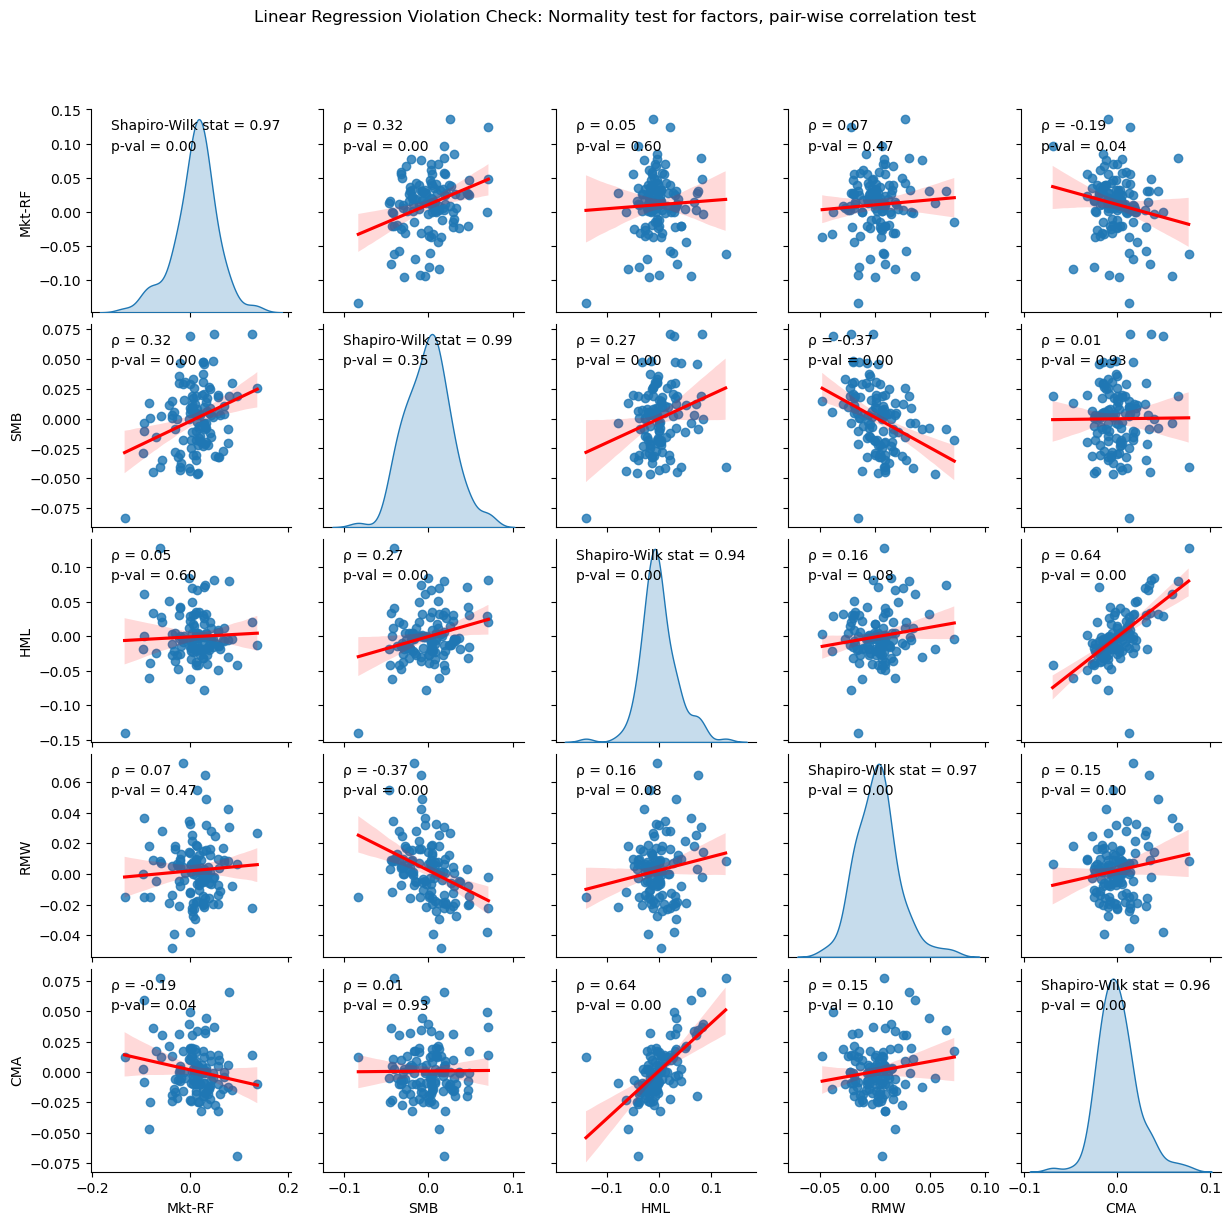

In [18]:
# Run EDA Functions on our dataset

# Generate pairplot
pp = sns.pairplot(df_ff_factors, kind='reg', diag_kind='kde',
             plot_kws={'line_kws':{'color':'red'}})

# Run the R2func for all off diagnonal cells, and normalityfunc for the diagonal ones...
pp.map_lower(R2func)
pp.map_upper(R2func)
pp.map_diag(normalityfunc)

# Title...
pp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp

pp.fig.suptitle('Linear Regression Violation Check: Normality test for factors, pair-wise correlation test')

plt.show()


Eyeballing our data we can see from the frequency distributions on the diagonal, that all variables have approximately normally distributed. It can also be noted that HML and CMA are somewhat correlated, which may cause colinearity issues with the linear regression models we will use later.

# Stage3: Model Design

#### Bias Alert: Complexity Bias
There is a balancing act between model complexity and the data available, and if our model becomes too complex for the amount of data we will likely overfit to the data, and our model will not perform well out of sample. It will be a bad predictor. The more samples we have, and the more accurate the data, the more accurate our model will be. The more data we have the more features and model parameters  (ie complexity) we can employ to approximate our target function. 

In practice, historic simulations require relatively large amounts of data to avoid overfitting. A relatively long history of returns is required to learn a linear regrssion model with many input variables[1], less for a classification model. ML models generally have more parameters than traditional linear models and therefore we need even more data for training. In short, we may not have high enough frequency data to train a stable model. This problem is exaccerbated when running simulations, as to avoid data snooping biases we can only use a subset of our full dataset that preceeds each simulation date.   

For linear factor models, the analogue is that these models assume: 
$$N >> K$$
[2] , a serious limitation requiring explicit dimensionality reduction, in a world with expanding data resources .


So how much data do we need for our chosen model? And what is the maximum number of features we should use?

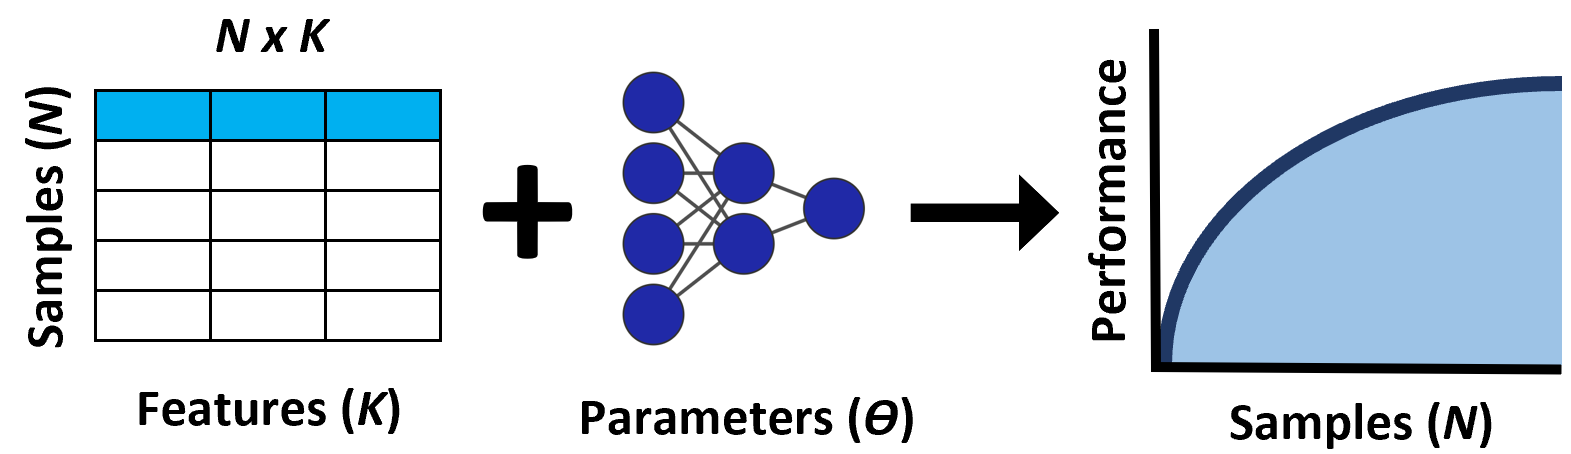


### Model complexity1: Instances vs features and classes used
A rule of thumb for the number of instances, N, needed to train a stable model with K input features, for a classification model with C categories to classify:

$N ≥ 10 K C$

instances. For a regression model:

$N ≥ 50 K$

instances are suggested.


### Model complexity2: Instances vs parameters
A rule of thumb for the limit on number of parameters, $|θ|$, our model should have, given the size of our training data [3], we suggest this: 

$|θ| ≤ N/10$ 


[1] Robert C. Merton, “On Estimating the Expected Return on the Market: An Exploratory Investigation,” Journal of Financial Economics, 8 (1980), pp. 323–361.

[2] Valliappa Lakshmanan, Sara Robinson, and Michael Munn. Machine learning design patterns. O’Reilly Media, 2020

[3] Kevin P. Murphy, Probabilistic machine learning: an introduction. MIT press, 2022

In [19]:
#***********************************************************************
#*** Complexity bias Sanity Check!***
#***********************************************************************  
def bias_complexity_check_regression(no_of_instances: int,
                          no_of_features: int = 0,
                          no_of_parameters: int = 0) -> (bool, int, int):

  '''
  Check the complexity of the mode based on rules of thumb.

  Args:
    no_of_instances: Number of rows in your dataset
    no_of_features: Number of columns
    no_of_parameters: Number of weights/coefficients/parameters in your model
      
  Returns:
      rf: sklearn model object
      
  Author:
      failed: Did the complexity check fail? Too complex...
      feature_max: maximum number of features you shluld have given the problem type and instances
      param_max: maximum number of weights/coefficients/parameters in your model given the problem type and instances
  '''

  failed = False
  cb_K = no_of_features
  cb_n = no_of_instances
  
  # 1. Feature complexity: n ≥ 50 K
  if cb_n > 50 * cb_K:
    failed = True
  
  feature_max = int(round(cb_n / 50, 0))

  # 2. Parameter complexity: ¦θ¦ ≤ n/10
  #
  # The number of model parameters (ie weights) should observe the constraint
  # wrt training instances, n, features, K:
  #
  # |theta| >= n/10  
  param_max = int(round(cb_n / 10, 0))
  
  if no_of_parameters > param_max:
    failed = True

  return (failed, feature_max, param_max)


## 3a. Traditional Quantitative approach: Linear Factors

We will use a fundamental factor model, also known as a time-series factor model, after Fama and French. This has the familar form:
$$
R_{it} = α_{i} + \sum\limits_{j=1}^{K} \beta_{ij} f_{ij} + ϵ_{ij} \qquad \text{where}\; i=1,\dots, N\; j=1,\dots, K
$$
Where $R_{it}$ is the return of stock $i$ at time $t$, $\beta$ is the exposure (loading) of stock $i$, representing an observed source of inefficiency such as value, $f$ is the return of a reference portfolio $j$. 

We use a vectorized version of this factor model, which is much faster:

$$
R_{t} = \mathbf{α +β f_{t} + ϵ_{t}}
$$


We will first learn the loadings of each stock to each of the factors in the dataset, and we will then use these loadings and the assumed future factor returns to determine the expected return of each stock to form model portfolios.     


#### Bias Alert: Researcher bias

Biases that can arise due to the researcher being influenced in both data collection, data exploration and modelling approaches proposed by previous research. Factor investing, provides a number of possible areas for researcher bias, including model design and factors to use.

#### Bias Alert: Sample Distribution Bias

If the training data and the actual data to be predicted come from different distributions, this would likely challenge to the generalization ability of a model (ie how well it performs on future input data). If a parametric model is used, such as a linear factor model, the risks of shifting distributions are likely to be greater still, as normality assumptions may be violated, even if normlization/standardization of the input data is carried out.   

We now specify our model training process, using OLS regression. We will wrap this up as a function, so as we can call it multiple times to generate return simulations over the study term.

Note that we sanity check parameters, to provide basic checks, and we analyse the residuals produced by the model to ensure residuals are normally distributed (using a SHapiro-Wilk test in this case, with the option of generating a scatter plot in the function too).
Let us run the function, using our 5 factor regression on the first security in the dataset, column=0.

Many refinements can be made to this simple model.

### 3a. i) Prepare data

Our data is ready and prepared to pass into our train and predict functions.


### 3a. ii) Forecast Stock Level Expected Returns

Now we need to declare a function to calculate factor loadings, or $\beta$ for each factor and each security in our stock universe using the function **factormodel_train_manysecurities** which you can find in the LinearFactorInvesting class in our repo.

We will then use these factor loadings to forecast the expected returns of our stock universe at a given time point (t) using the function **factormodel_forecast_er**. 

In [20]:
# Run the function with our data
df_all_er = LinearFactorInvesting.factormodel_forecast_all_er(df_benchmark_trades=None,
                                        df_tb3ms=df_tb3ms, 
                                        df_sec_rets=df_sec_rets,
                                        df_ff_factors=df_ff_factors,
                                        window_size=36)


# Test an example
test_this_stock = df_all_er.columns[0]
df_all_er.columns.get_loc(test_this_stock)

0it [00:00, ?it/s]

0

### 3a. iii) Test run of our model

Let us call our function (**factormodel_train_single_security**) to train a factor model for the first security in the dataset  using the past 36months, and then calculate this security's expected returns (**factormodel_forecast_er**). We will also opt to generate a residual plot (by setting factormodel_train_single_security parameters to plot_residual_scatter=True).
Our function will also print the summary stats for the regression.
Finally we will set a sanity check for normality of the redisuals. If the Shapiro-Wilk test produces a p-val of >10\% we can accept the null hypothesis, implying that the distribution of residuals is normal. 

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.


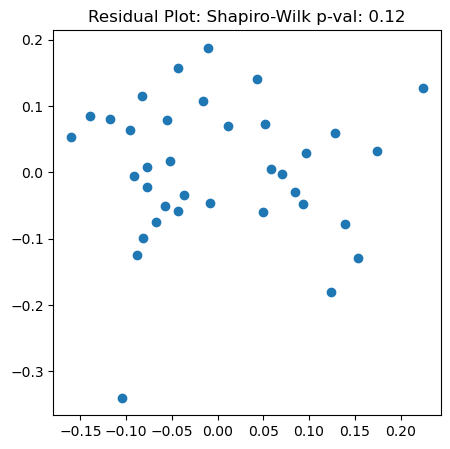

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     6.810
Date:                Tue, 17 Jan 2023   Prob (F-statistic):           0.000237
Time:                        00:22:54   Log-Likelihood:                 33.008
No. Observations:                  36   AIC:                            -54.02
Df Residuals:                      30   BIC:                            -44.52
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0093      0.020     -0.473      0.6

In [21]:

# Get an example equity
i = df_sec_rets.columns.get_loc('VSEC-US') 
t = 19

# Run our function on the first security (sec_col_no=0), returning only the model object, and Shapiro-Wilk stat and p-value
ols_model, y, y_hat = LinearFactorInvesting.factormodel_train_single_security(sec_col_no=i, 
                                             df_tb3ms=df_tb3ms, 
                                             df_sec_rets=df_sec_rets, 
                                             df_ff_factors=df_ff_factors, 
                                             date_start=t+36, 
                                             date_end=t, 
                                             plot_residual_scatter=True)
# Examine the fit, coefficients and OLS analytics.
print(ols_model.summary())

# Forecast E(R) for this security.
df_stock_er = LinearFactorInvesting.factormodel_forecast_er(df_stock_factor_loadings=pd.DataFrame(ols_model.params, index=None), 
                                df_ff_factors=df_ff_factors, 
                                r_f=df_tb3ms.iloc[0,0],
                                date_start=t+36, 
                                date_end=t,)

print("Expected Return Forecast for this stock")
print(df_stock_er)


### 3a. iv) Select Top Quartile Stocks

In each period we select the top quantile (defaulting to 25th percentile) of our stock forecasts, and generate a DataFrame of equal weighted stocks that reside in this quantile.
Next we assume a certain rebalance frequency, and simulate the past returns of this portfolio. 

#### Bias Alert: Backtesting Bias

Back-testing bias includes forward-look (or data snooping) bias, where an analyst will check the performance of an approach over the past, and will tend to reject all approaches that perform poorly. In a sense the analyst becomes endogenous to the model, using a look-ahead to bias model selection to only those models that have worked well. 

This issue can be addressed by testing only a small number of approaches (i.e., avoiding violation of independence assumptions) with strong investment rationales (i.e., causality) and/or by comparing the simulated returns to the possible empirical outcomes using target shuffling. 

#### Bias Alert: Time-Interval/Forward Look Bias
When researcher selects a specific timeframe for training vs. validating vs. testing to support hypotheses and/or uses “restated” data not available during the time under study. 

In [22]:
# Get the top 25% of stocks by exepected return over the study term
df_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_all_er, 
                                        rebalance_freq=6, 
                                        min_quantile_to_buy=0.75)

0it [00:00, ?it/s]

Top quantile generated


### 3a) v) Factor Model: Historic Return Simulation
Now we can join the steps up to carry out the following steps at each rebalance date across the study term:
1. Forecast Stock Level Expected Returns
2. Select Top Quartile Stocks

And we can they pass the resulting positions into a **sim** function to ...

3. Simulate Returns

Take the trades we have just generated and run a historic simulation.

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

,Analytics
Total Return (TR)(annualized),0.120638
Standard deviation (SD) (annualized),0.286069
Sharpe Ratio (TR/SD),0.421711
Hit rate (monthly),0.636364


,Descriptive Stats
Mean (TR),0.013032
Median (TR),0.012940
Variance (TR),0.006820
Skewness (TR),-0.021185
Kurtosis (TR),1.542542


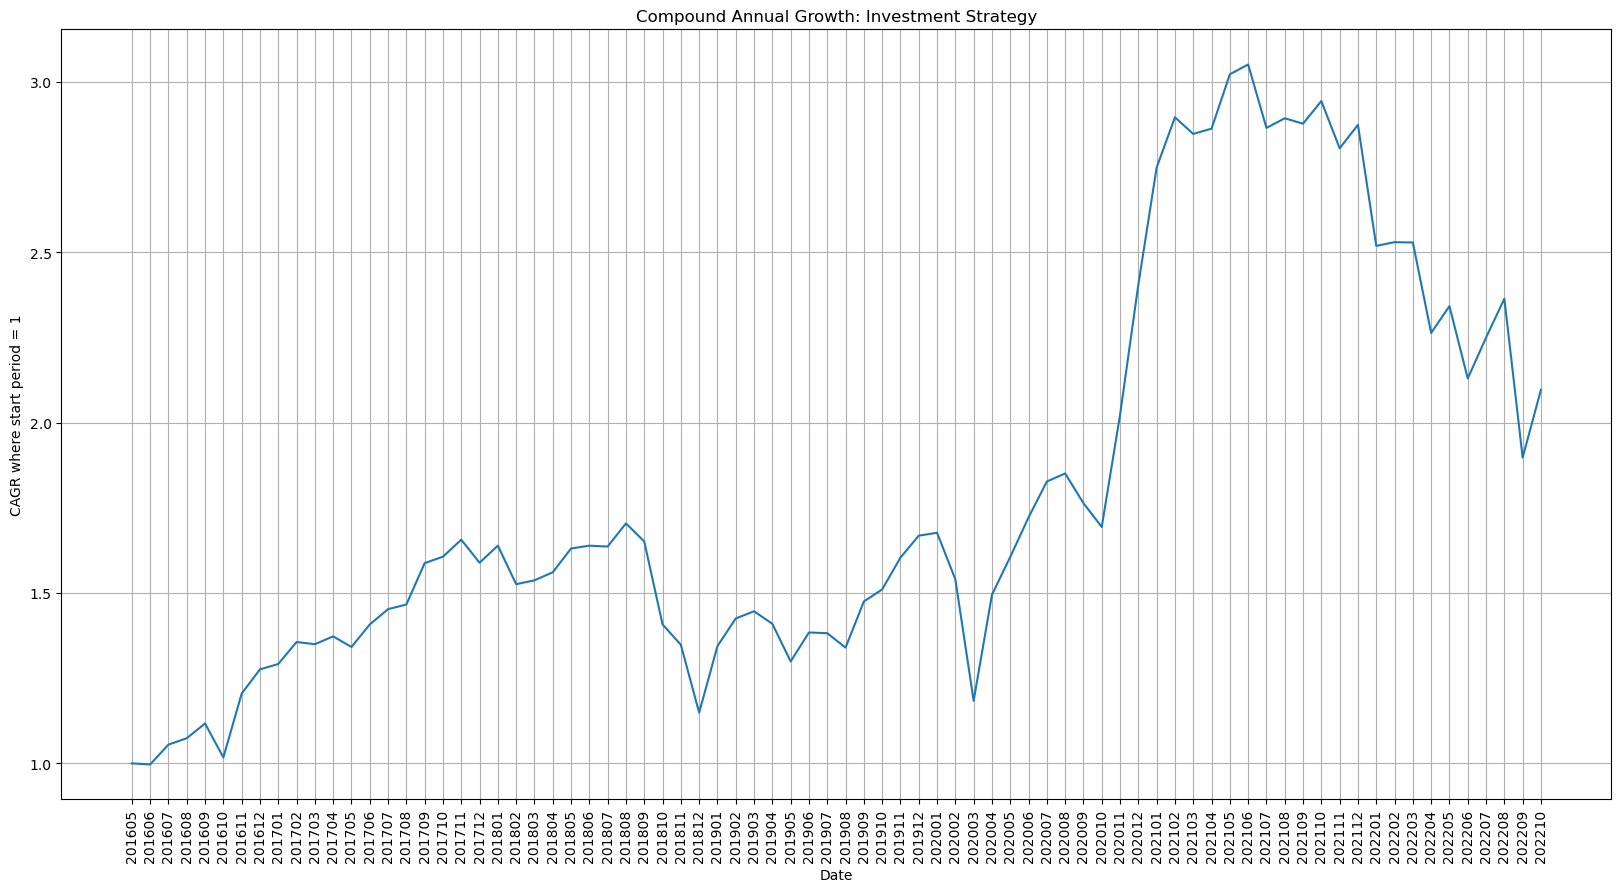

In [23]:


#====================================
# Run the Linear factor model
#====================================

# FF model
df_lin_all_er = LinearFactorInvesting.factormodel_forecast_all_er(df_benchmark_trades=None,
                                        df_tb3ms=df_tb3ms, 
                                        df_sec_rets=df_sec_rets,
                                        df_ff_factors=df_ff_factors,
                                        window_size=36,
                                        winsorize_er=0)

# Run the function to establish simple positio sizes based
df_lin_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_lin_all_er, 
                                        rebalance_freq=6, 
                                        min_quantile_to_buy=0.75)

# Run the simulation function
df_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         date_start_of_sim=79)  


Now we construct a simple benchmark from our universe...

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

,Analytics
Total Return (TR)(annualized),0.118827
Standard deviation (SD) (annualized),0.216353
Sharpe Ratio (TR/SD),0.549228
Hit rate (monthly),0.688312


,Descriptive Stats
Mean (TR),0.011500
Median (TR),0.014161
Variance (TR),0.003901
Skewness (TR),-0.675099
Kurtosis (TR),2.545039


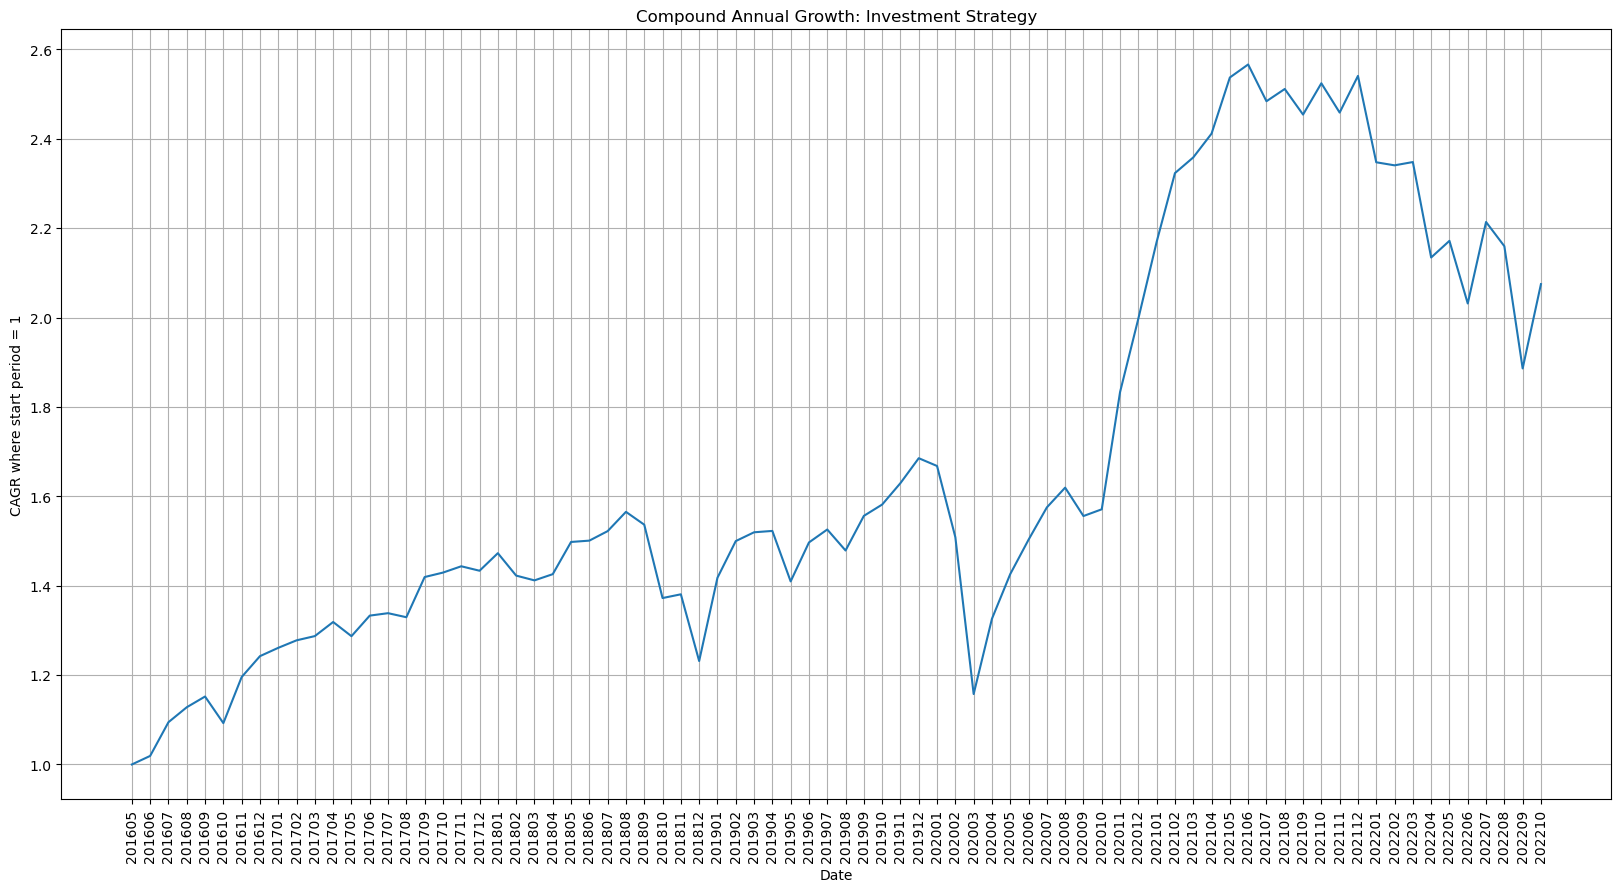

In [24]:
#====================================
# Create universe benchmark
#====================================
# Run the function to establish simple positions
df_benchmark_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_lin_all_er, rebalance_freq=6, min_quantile_to_buy=0)

df_sec_rets_copy = df_sec_rets.copy(deep=True)
df_sec_rets_copy[df_sec_rets_copy>5] = 5

# Create an equal weighted benchmark of all valid securities
# Run the simulation function
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, 
                                    rebalance_freq=6, 
                                    df_sec_rets=df_sec_rets_copy, 
                                    date_start_of_sim=79)  

0it [00:00, ?it/s]

,Analytics
Total Return (TR)(annualized),0.120638
Standard deviation (SD) (annualized),0.286069
Sharpe Ratio (TR/SD),0.421711
Hit rate (monthly),0.636364


,Descriptive Stats
Mean (TR),0.013032
Median (TR),0.012940
Variance (TR),0.006820
Skewness (TR),-0.021185
Kurtosis (TR),1.542542


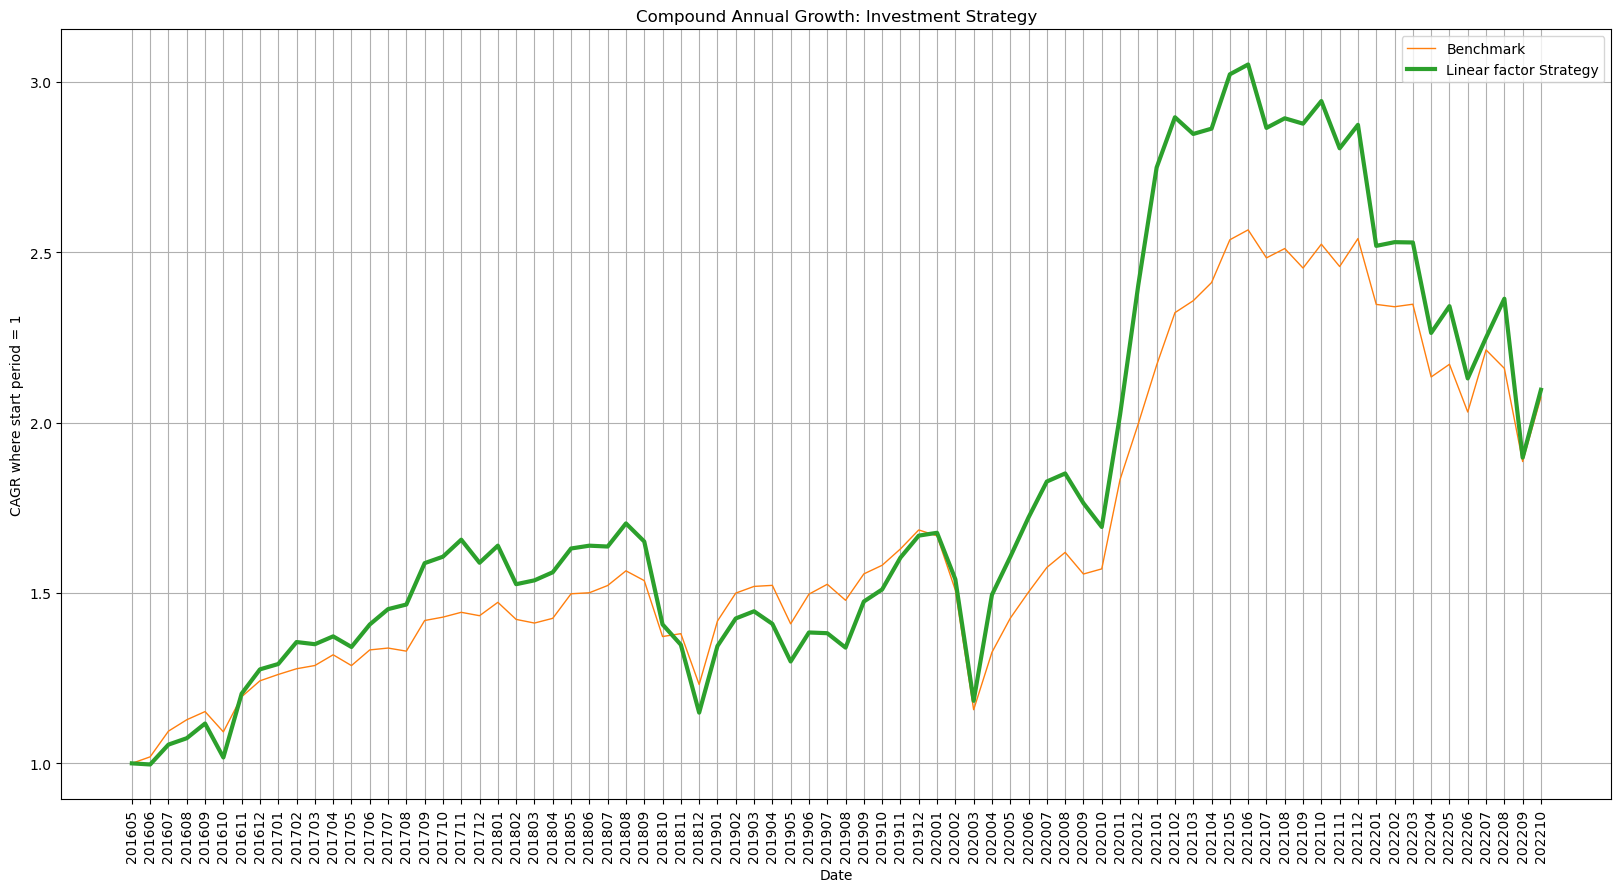

In [25]:
# Plot the linear-factor model CAGR vs the benchmark
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         print_chart=False,
                         date_start_of_sim=79)  

# Chart
p = SimulationUtils.sim_chart(df_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy', emphasize=True)
p.legend()
p.show()

### 3a) v) Factor Model: Judging model performance

Return simulations can give a misleading impression of how significant performance or risk adjusted returns would have been. As we saw in previous modules, we can construct an empirical distribution of possible returns using "target shuffling" (note that we use the "lite" version here). This allows us to look at many of the combinations of securities we could have held over the study term (using the same assumptions as our simulation: same number of stocks as the portfolio and the same rebalance periods and so on). A comparison of our simulation with this emiprical distribution gives us a much better feel for how good the performance of our model is relative to other possible strategies with similar assumptions.

In [26]:

# get an empirical distribution of oucomes.
dt_target_shuffling_dist = RobustInvestmentUtils._target_shuffling_lite_get_dist(df_opportunity_set_trades=df_benchmark_trades,
                                      min_quantile_to_buy = 0.8,
                                      df_sec_rets=df_sec_rets,
                                      rebalance_freq=6,
                                      iterations=100)



0it [00:00, ?it/s]

Factor Model


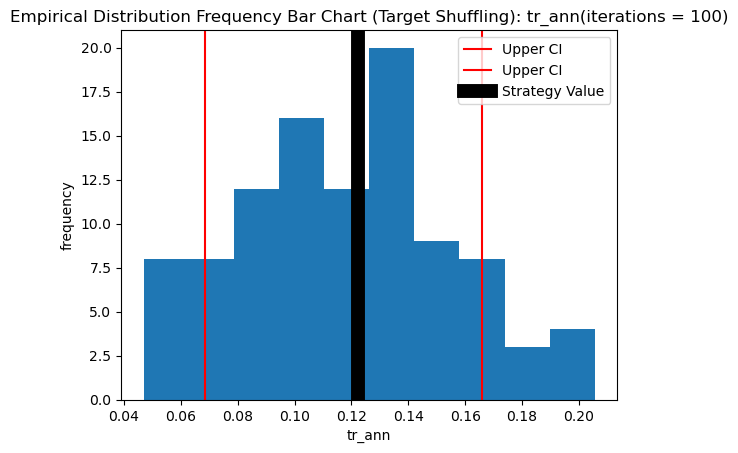

Empirical probability value of the strategy: tr_ann:0.53
Benchmark


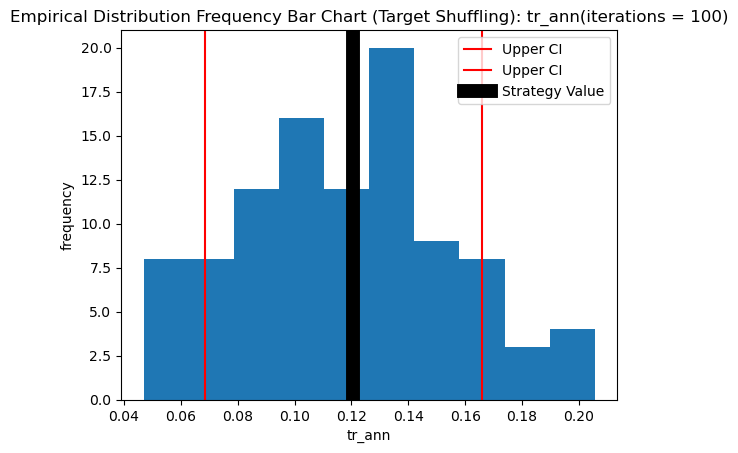

Empirical probability value of the strategy: tr_ann:0.53


In [27]:
# check the performance of the simultation using target shuffling lite, to form an empirical distributon of returns
# simulation...
print('Factor Model')
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_lin_sec_cagr)
# benchmark
print('Benchmark')
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_benchmark_sec_cagr)

In [28]:
dt_target_shuffling_dist

,cagr,tr_ann,sd_ann,sharpe
0,1.607238,0.076754,0.220456,0.348159
1,1.790129,0.094991,0.230813,0.411549
2,1.678829,0.084091,0.243941,0.344721
3,1.655338,0.081713,0.245007,0.333515
4,2.007115,0.114690,0.223223,0.513792
...,...,...,...,...
95,3.314523,0.205326,0.252775,0.812289
96,1.356153,0.048623,0.239037,0.203413
97,1.892913,0.104560,0.234536,0.445815
98,1.978275,0.112179,0.232467,0.482558


#### Bias Alert: Certainty bias

Any opinion offered about the probability, likelihood, certainty, or similar property for a hypothesis cannot be derived from statistical methods alone. In particular, significance tests and confidence intervals do not by themselves provide a logically sound basis for concluding an effect is present or absent with certainty or a given probability. This point should be borne in mind whenever one sees a conclusion framed as a statement of probability, likelihood, or certainty about a hypothesis. Information about the hypothesis beyond that contained in the analyzed data and in conventional statistical models (which give only data probabilities) must be used to reach such a conclusion; that information should be explicitly acknowledged and described by those offering the conclusion. Bayesian statistics offers methods that attempt to incorporate the needed information directly into the statistical model; they have not, however, achieved the popularity of P values and confidence intervals, in part because of philosophical objections and in part because no conventions have become established for their use.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4877414/

#### Bias Alert: Endogenous bias
Endogeneity bias is not a simple violation and there is no easy statistical solution. It has serious consequences for outcomes, where in the presence of endogenous variables OLS learns biased and inconsistent parameters. P-values can be seriously misleading. All it takes is one endogenous variable to seriously distort ALL OLS parameters.
https://artnet.unescap.org/tid/artnet/mtg/gravity09_tues3.pdf

One potentially concerning endogeneity is self-fulfilling prophecy of factor investing, where stocks with high correlations to commonly used factors would cause investments in those stocks, causing price appreciation, affirming that the correlations with those factors caused the price rises.


## 3b. Factor Approach with Non-linear Regression

We now examine using machine learning tools, applied to a traditional quantative framework.
Traditional linear factor approaches, after Fama and French, assume persistent long-run returns of factors, and that a stock's loadings to these factors can be (linearly) mutliplied into factor returns to find their expected return. This is likely to be a flawed assumption as stock returns do not move in straight lines with respect to factor returns. Instead of keeping this assumption, we can add a nonlinear element to the relationship between our stocks' factor loadings and returns. We can train a ML model, in this case a neural net, to find a nonlinear function to fit all of our $N$ stocks' $K$ loadings, $\beta_ij$, to all their returns, $R_{it}$:

$$
R_{it} =\overset{̃}{f}_{j=1}(β_{i1}, β_{i2}, …, β_{iK}, f_{i1}, f_{i2}, …, f_{iK})
$$

Where $R_{i}$ is the return of stock $i$ at time $t$, $\beta$ is the exposure (loading) of stock $i$, representing an observed source of inefficiency such as value, $f$ is the return of a reference portfolio $j$. 


To approximate the function $\overset{̃}{f}()$ is substantially more complex than simply assuming a linear relationship as factor models dosince it requires both the determination of this complex function.
While we may be shedding an oversimplistic assumption linear models make, we are now open to all sorts of biases in constructing our approach.

We will use an MLP neural net. To avoid ovefitting of neural net, ML is typically separated into a train and test data. Additionally, we are taking on much more complexity with this nonlinear features, with many hyperparameters needing to be specified, such as the size of the hidden layer, activation functions to choose, learning rate, and so on. The following neural net has been heuristically tuned, ie by trial and error, and this process took about 30minutes to complete. If you try changing the settings in the MLPRegressor's fit function yourself, you will see how variable the predictions are from this model. There is huge sensitivity to the typs of normalization use, the activation function used and so on. All this implies a lack of stability. Our message: avoid complex models to avoid biases. 



The MLP we will use has the following architecture, where the 11 input units relate to our 6, stock level factor coefficients (ie 5 $β$s, one $α$), and 5 corresponding factor returns over the longer run $f$. The architecture is shown with on hidden-layer, of 5 hidden units, and one output $R$.

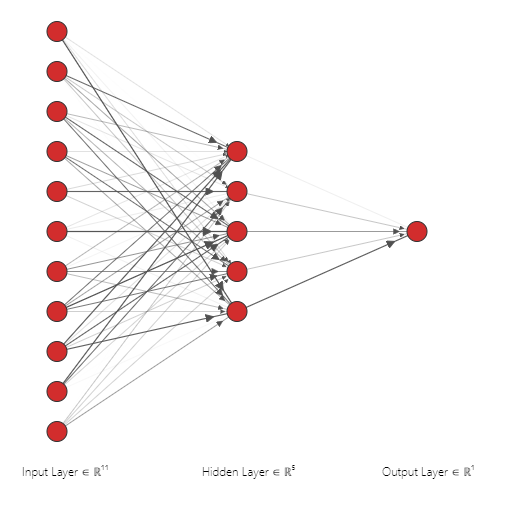

### Bias Alert: Normalization Data Snooping bias

For neural nets we almost always need to normalize (or standardize) the input data. There is room for a weak form of data snooping bias though, in historic simulations. 
We can either normlize by row (ie across a given stock's datapoints), so that each column is in proportion to the row. Or we can normlize by column. 

For stock selection applications row level normalization makes less sense, because taking PE ratio as an example, you want to compare one stock's PE ratio versus the PE ratio of all others; ie column normalize. It makes little sense to row normalize, where a stock's PE is scaled against the same stock's EBITDA/EV.  
The bias arises when we column normalize (or standardize) training data to train our model, and then pass in new data for forecasting, which may contain different min and maxes in each column. In this case all the column scalings will slightly change if the min max range changes from the training data.
In this case we can either live with the inaccuracy, or save the min-max training range and normalize the new data to the training range, capping the min/max at the training min/max, or allowing the min/max to exceed the -1/+1 range typically used for min/max scaling.


### Bias Alert: Repeated testing (multiplicity) bias

Complex machine learning approaches generally have many hyperparameters, such as neural nets, with the number of hidden nodes, the learning rate, optimizer used, activation function and so on. It is standard practices to conduct a grid search of these hyper parameters, known as hyperparameter tuning, until we find the optimum comdination. This is a problem if we are hypothesis testing the results of our model, for instance sampling the R2, and F-stat of the goodness of fit of our prediction, because the p-val is calculated to assume the probability of one test being conducted. This is known as multiplicity bias.   

Applying many tests in a single study results in an increased probability of detecting a significant finding just by chance (the problem of multiplicity). It then discusses some of the methods that have been proposed for correcting for multiplicity, including single-step procedures (e.g., Bonferroni); multistep procedures, such as those of Holm, Hochberg, and Šidák; false discovery rate control; and resampling approaches. 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3015194/

### 3b i) Prep data for training/predicting

In this section we declare the function to calculate stock returns we will need as the $y$ variable for our neural net function: stock_rets_get.
We also need a function to generate the 11 inputs to the neural net: nonlinfactor_er_func_prep_data

It is a great help to have a function that wraps up the preparation of our data for training and predicting. The following function does this, where we can pass in our raw data and have it shaped for purpose.

### 3b. ii) Train, and Forecast Functions

Now we need functions to train our neural net, and to provide the final forecast of stock returns in a given time period. 
We will need these function to generate expected returns which will feed into our trade generating function, decaled earlier, and our simulation function, declared earlier.

p-value may not be accurate for N > 5000.


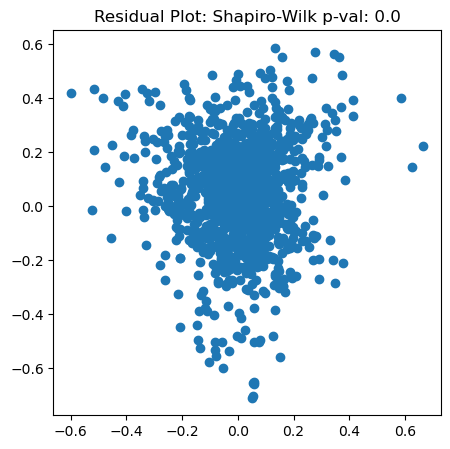

R2: 0.63; F-stat: 215.28


In [29]:
# train nn 
nn_model, X_nlf, y_train_nlf, y_hat_nlf = NonLinearFactorInvesting.nonlinfactor_train_er_func(df_tb3ms=df_tb3ms, 
                                              df_sec_rets=df_sec_rets,
                                              df_ff_factors=df_ff_factors,
                                              date_end=0,
                                              forecast_ahead=6,
                                              window_size=36,
                                              func_training_period=12,
                                              plot_residual_scatter=True)


### Bias Alert: Complexity Bias
Using a complex model such as a neural net may be appealing but number of parameters the model needs to have trained may exceed our rule of thumb for complexity. It may in anycase, not an ideal learner to apply, if a more simple approach achieves a similar result. 


In [30]:
# count the number of parameters in the MLP
param_count = 0
for i in range(0, nn_model.coefs_.__len__()):
  param_count += nn_model.coefs_[i].shape[0]


# Sanity Check: Biases ************************
failed, _, _ = RobustInvestmentUtils.bias_complexity_check_regression(no_of_instances=36, # Try to use  36month window to train the MLP
                                    no_of_features=X_nlf.shape[1]-1, # Do not count intercept
                                    no_of_parameters=param_count) 
if failed == True:
  print("************ Complexity bias warning ***************")  
# Sanity Check: Biases ************************

************ Complexity bias warning ***************


It is also possible to examine the MLP model, using SHAP. Which inputs most influenced the return outcomes in the period we used to training the model?

In [31]:
import shap

# skip this bnit? It tales a while
if False:
  # SHAP XAI on the training data
  X_nlf_sample = shap.sample(X_nlf, 100)
  explainer = shap.KernelExplainer(nn_model.predict, X_nlf_sample)

  # Supress warnings
  with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(shap.sample(X_nlf, 100))
    shap.summary_plot(shap_values, X_nlf_sample.values, feature_names=X_nlf_sample.columns)

In [32]:
df_sec_rets

TICKER,WW-US,WABC-US,VVR-US,VSEC-US,VCV-US,URG-US,ULH-US,UEIC-US,TWO-US,TELL-US,...,ATRI-US,APYX-US,APOG-US,AORT-US,ALNY-US,ALIM-US,ALG-US,AGM-US,ACAD-US,AAON-US
DATE,,,,,,,,,,,,,,,,,,,,,
202210,0.150127,0.199656,0.019447,0.307627,-0.022223,0.183486,0.008827,0.037621,0.072289,0.129707,...,0.062496,0.113586,0.206526,-0.193642,0.035472,0.027559,0.245407,0.161993,-0.020171,0.196919
202209,-0.247126,-0.065416,-0.029658,-0.154122,-0.108736,-0.210145,-0.128667,-0.115160,-0.280412,-0.402500,...,-0.061173,-0.216405,-0.064153,-0.375451,-0.031499,-0.248521,-0.064928,-0.084162,-0.004260,-0.062630
202208,-0.213855,-0.061024,-0.001197,-0.002384,-0.059334,0.159664,0.214975,-0.198919,-0.098513,0.075269,...,-0.106451,-0.394292,-0.018505,0.130612,0.455013,0.183888,0.010432,-0.009520,0.118448,-0.044707
202207,0.039124,0.078153,0.006915,0.119599,0.027597,0.122642,0.100330,0.085256,0.117725,0.248322,...,0.074802,0.614334,0.067074,0.038136,-0.026123,0.043876,0.113214,0.129442,0.042583,0.098795
202206,-0.098731,-0.075569,-0.011145,-0.032939,-0.031999,-0.131148,-0.017249,-0.045896,-0.067416,-0.375262,...,0.003267,-0.034596,-0.057212,-0.034765,0.159380,-0.103279,-0.010201,-0.060446,-0.127554,0.025527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201303,-0.012952,0.023251,0.036143,0.090790,-0.042989,0.284106,0.279057,0.189867,0.080144,-0.018349,...,-0.018891,0.231343,0.122528,-0.015577,0.028704,0.023333,0.069033,-0.084336,0.308072,0.146717
201302,-0.198803,-0.002701,0.011011,-0.042491,0.012045,-0.151685,0.016722,0.023037,0.035427,-0.035398,...,-0.021296,-0.025455,0.058740,-0.045171,-0.018235,0.530612,0.053592,-0.016322,0.006633,0.058047
201301,0.021199,0.051655,0.075584,-0.020400,0.007656,0.052134,-0.016986,-0.012920,0.120939,0.225597,...,0.023010,0.136364,0.020025,0.030498,0.322192,0.248408,0.042554,0.055692,0.296774,0.089602


Now we can implement a function that applies the forecasting function over the study term, ready for historic simulation testing.

In [33]:

# Run the function with our data
df_nlf_all_er, nn_mod_latest = NonLinearFactorInvesting.nonlinfactor_forecast_all_er(df_benchmark_trades=df_benchmark_trades,
                                                            df_tb3ms=df_tb3ms, 
                                                            df_sec_rets=df_sec_rets,
                                                            df_ff_factors=df_ff_factors,
                                                            window_size= 36, 
                                                            func_training_period=24)

0it [00:00, ?it/s]

### 3b) iii) Non-linear Factor Model: Historic Return Simulation
Using our simulation functions decalred earlier, we can run a simulation using our non-linear factor model.

Finally we run our stock selection and simulation functions, applied to the non-linear factor approach...

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

Run simulations from a common start date...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Generate charts...


,Analytics
Total Return (TR)(annualized),0.029231
Standard deviation (SD) (annualized),0.246822
Sharpe Ratio (TR/SD),0.118428
Hit rate (monthly),0.536585


,Descriptive Stats
Mean (TR),0.005018
Median (TR),0.008646
Variance (TR),0.005077
Skewness (TR),-0.571963
Kurtosis (TR),1.167324


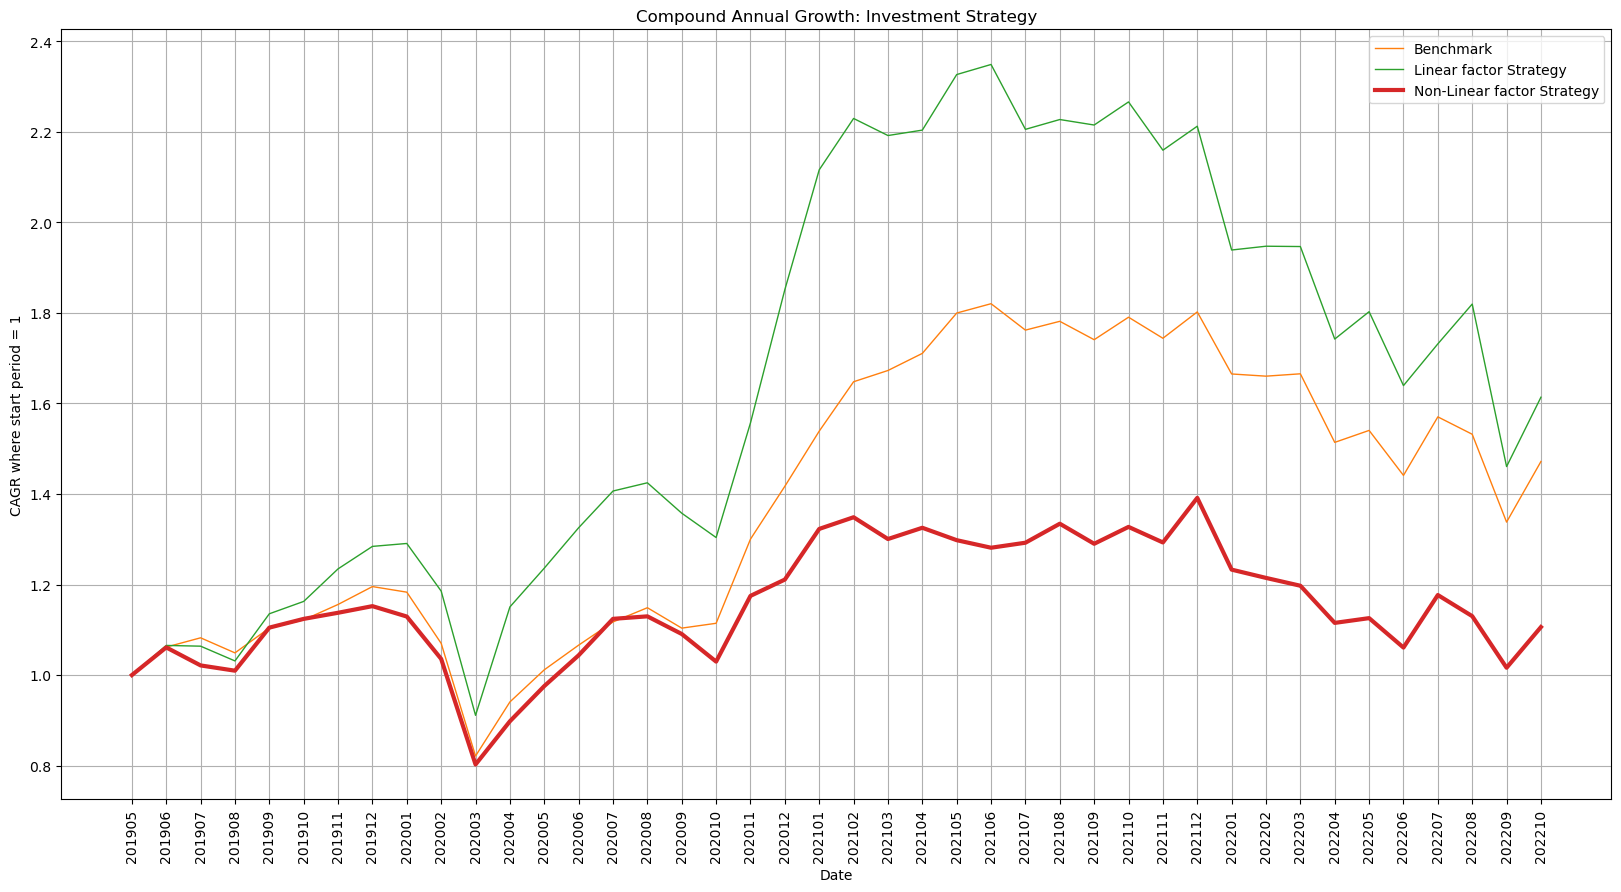

In [34]:
# Run the function to establish simple trades
df_nlf_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_nlf_all_er, rebalance_freq=6, min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_trades)),
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         print_chart=False)  

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_non_lin_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy', emphasize=True)
p.legend()
p.show()

### 3) b) iv) Non-linear Factor Model: Judging model performance

Target shuffling lite results indicate that our performance may not be just by chance.

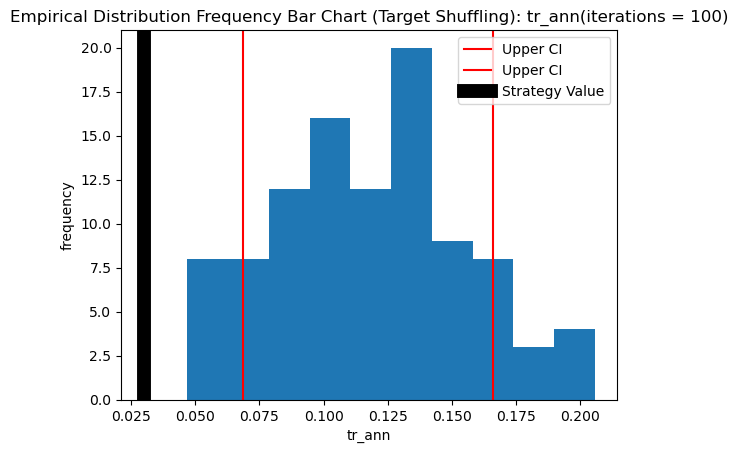

Empirical probability value of the strategy: tr_ann:0.0


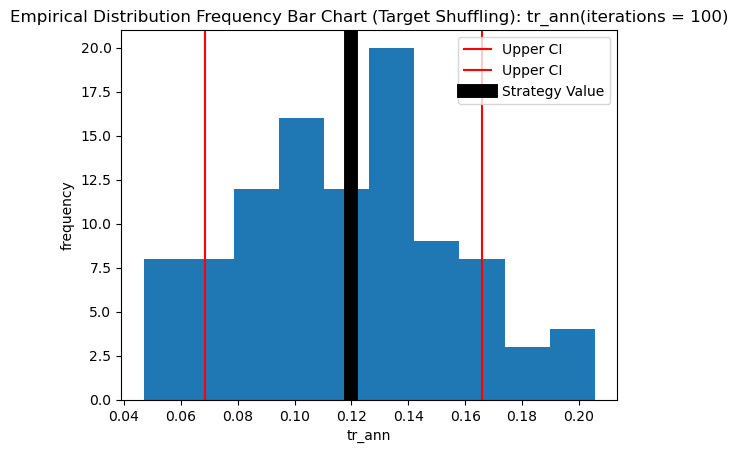

Empirical probability value of the strategy: tr_ann:0.53


In [35]:
# check the performance of the simultation using target shuffling lite, to form an empirical distributon of returns
# simulation...
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_non_lin_sec_cagr)
# benchmark
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_benchmark_sec_cagr)

## 3c. Interpretable Machine Learning Approach


Now, rather than using a ML retrofit to traditional quantitative investing approach, we will use a purpose designed machine learning approach that has the follow important properties that will help us mitigate many traditional biases. Symbollic artificial intelligence (SAI) [1], where the symbols are actually investment-rules. This ML approach will automatically select the most important inputs, find associations between our input features and our ground truth, and comes with the following distrinct advantages over traditional quantative methods:

- **Interpretable**: SAI produces investment rules, analogous to Graham and Dodd's rules, rather than many coefficients (eg betas), hyperparameters (eg sliding window size) and model parameters (eg neural net weights).
- **Fewer assumptions**: SAI has far fewer assumptions to violate than traditional factor models, thereby avoiding many of the traditional biases. 
- **Feature selection/extraction**: SAI selects the most important features and uses these to drive the model. It does not require manual specification of factors as traditional factor approaches do. This is a significant advantage.
- **Interactions between inputs**: SAI learns simple interactions between features, rather than needing them manually specified and supplied to the model as traditional factor approaches do. (For example, whether the investment case for a stock with lower profitability can be mitigated by fast rising earnings, or a strong balance sheet?). 
- **Unaltered fundamental information**: SAI can ingest mainly unaltered data, such as financial analytics and exchange level data, macro data and so on; whereas traditional factor models require significant pre-processing (eg dimensionality reduction, such as PCA, differencing, normalization) which can lose potentially vital information.
- **More accurate Ground Truth via Multitask learning**: The ground truth of an investment strategy is generally more than, select stocks that simply "outperform". While traditional quant approaches tend to treat risk adjusted returns as the ground truth, target style and characteristics are also critical, such as defensiveness, growth or value characteristics. SAI allows for multiple objectives to be easily built into a ground truth unlike traditional factor approaches.
- ** Causal inference **: SAI, as an investment rule learning approach, can select only rules that exhibit a higher "lift" (explained later), confidence or odds-ratio, all of which can hint at the causality behind a rule.

[1] Philps, D., Tilles, D., & Law, T. (2021). Interpretable, Transparent, and Auditable Machine Learning: An Alternative to Factor Investing. The Journal of Financial Data Science, 3(4), 84-100 https://jfds.pm-research.com/content/early/2021/09/22/jfds.2021.1.077


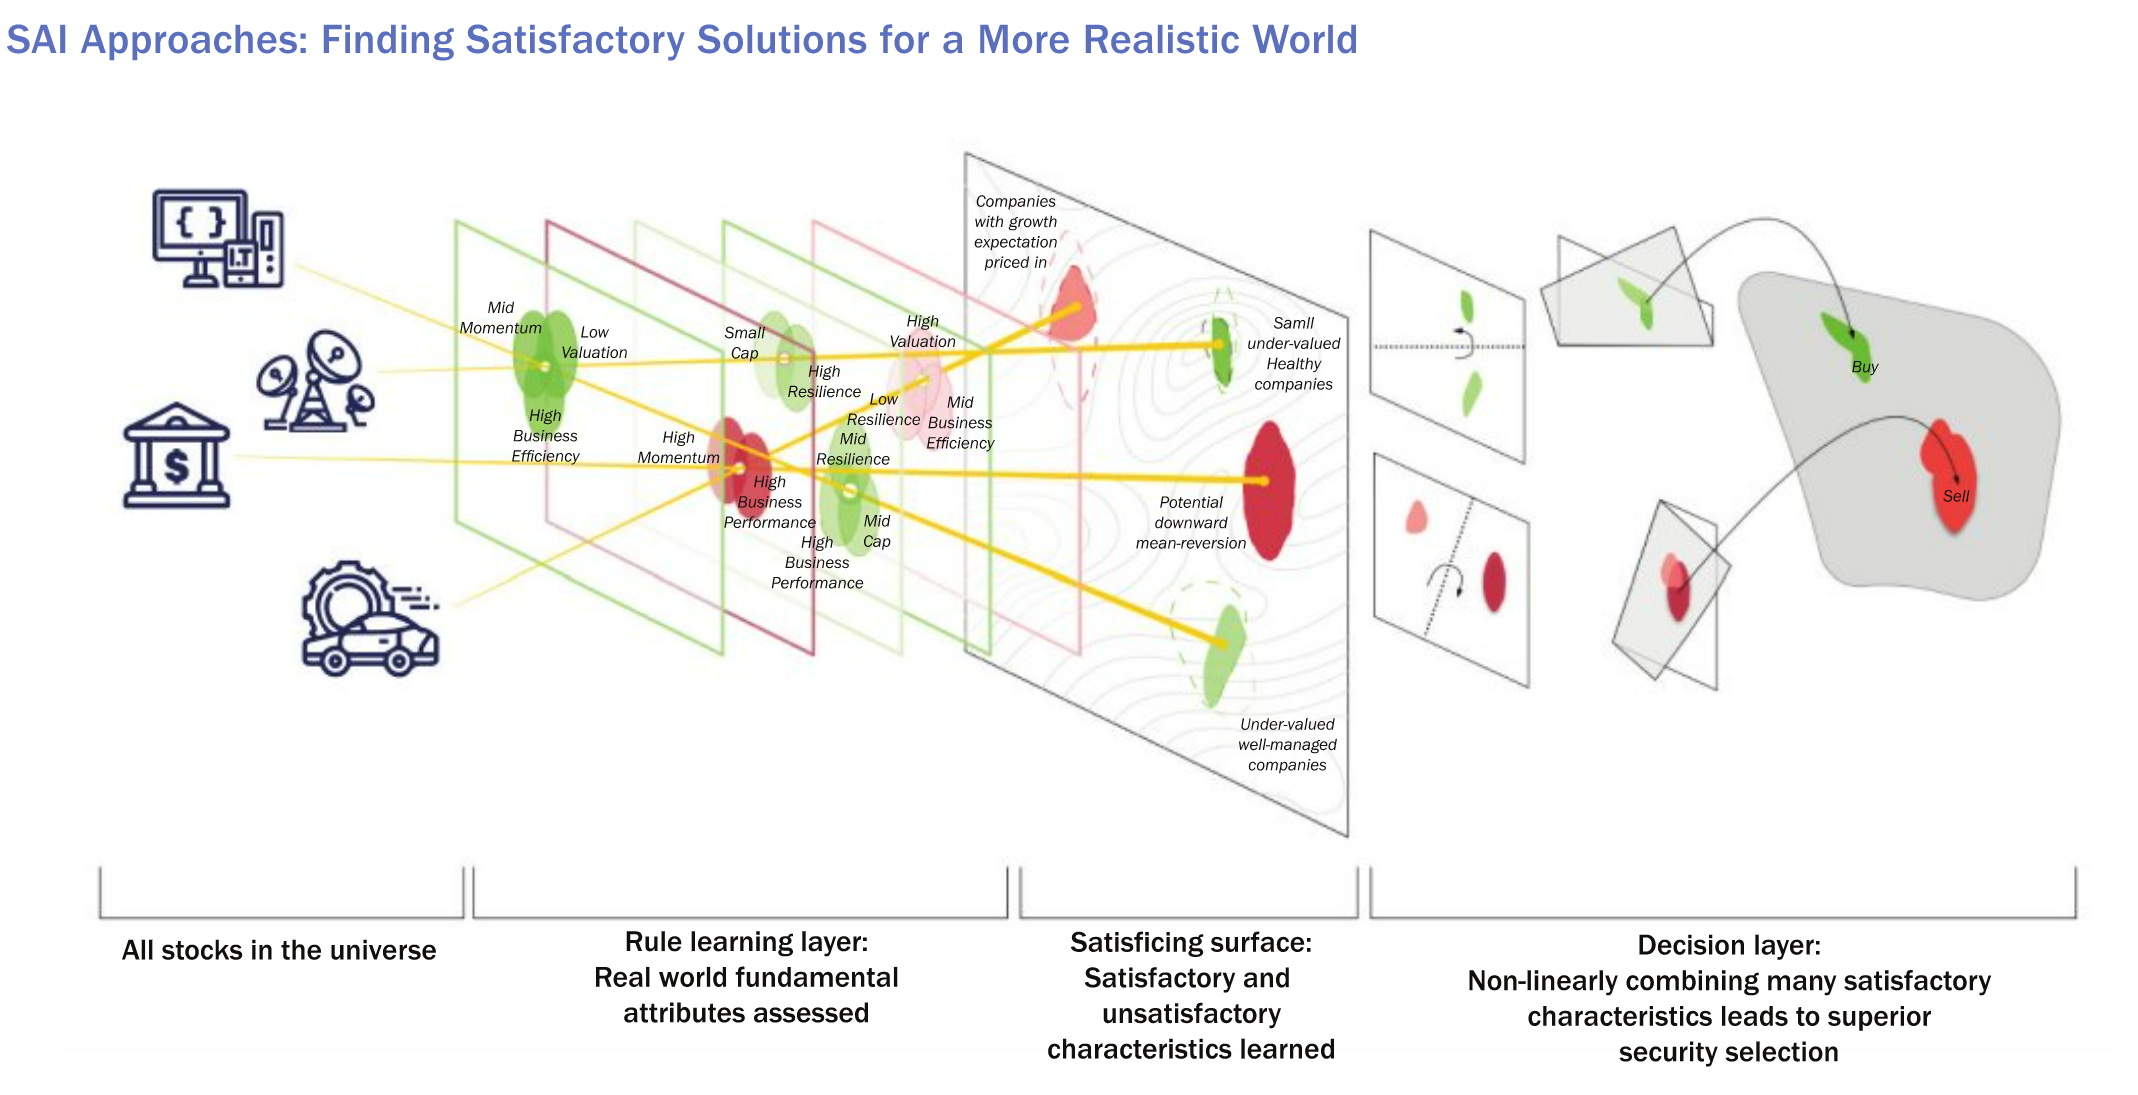

### Mitigating Biases: Rules based ML
Rules based ML, or symbolic ML, can avoid many of the biases in parametric investment models, and address the problem of explainability in ML models. Rules can also be learned using as complex an ML pipeline as is appropriate. 

#### Nonparametric
Rules based stock selection is considered to be non parametric (although rule learning may be parametric), assuming no distribution, thus avoiding many of the violations of parametric models as a result. Unlike many forms of machine learning, rules are also interpretable, allowing stake holders to review investment rules to gain some understanding of the way a model is operating. 

#### Stock Selection as a Classification Problem
Rules are also most easily considered as a classification problem, which requires less complexity than regression problems. As a classification problem, fewer data points and more features are able to be used under our complexity rules of thumb.
Certain rule learning approaches can be applied to a high number of features, avoiding the need for explicit dimensionality reduction, which itself can introduce further inductive biases and assumptions (eg PCA).

#### Causal Inference
Rather than using traditional frequentist statistics (such as t-stats of OLS betas), SAI learns rules based on associations with hints of causality. For example, odds ratios, confidence scores and "lift" can all be used to learn SAI's rules. Lift determines the relative probability of a "treatment" on an outcome:

$ lift = \frac{P(return>x|A)}{P(return>x, A)} $

Where $x$ is the desired return threshold, $P(return>x|A)$ is the conditional probability of a stock with a return above the required return threshold also having a feature $A$, $P(return>x, A)$ is the random chance a stock with a return above the required return threshold also has a feature $A$.


The SAI approach generates rules we can use to select stocks.


Import it...

In [36]:
from investsai.sai import SAI 


### 3c i) Prep data for training/predicting

For SAI our data preparation function to generate X and y variables is different. Firstly, the X variables are features, ie anything that might drive the model to find a better outcome. This can include traditional factors, but can also include fundamentals, valuations, ratios, sentiment scores, macro data affecting the country of a stock, and just about any other numeric attribute relevant to stock selection.
Rule learning includes feature selection, where the rules can be applied to potentially thousands of input features. Traditional quant models, in contrast, require explicit dimensionality reduction and the specfic selection and/or engineering of factors.


In [37]:

# Get training and test data to pass into SAI 
sai_X, sai_y = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=dict_sec_ff, #<< Pass populated dict None,
                                  df_ff_factors=df_ff_factors,
                                  date_end=0,
                                  buysell_threshold_quantile=0.75,
                                  forecast_ahead=6,
                                  window_size=24,
                                  func_training_period=3)
sai_X

,const,mkt-rf,smb,hml,rmw,cma,ff_net_mgn,ff_oper_mgn,ff_roa,ff_roe,ff_rotc,ff_tcap,ff_pbk,ff_pcf,ff_pay_out_ratio,ff_pe
ticker,,,,,,,,,,,,,,,,
WW-US_6,-0.041362,1.544865,2.120049,0.511634,0.922267,1.630833,5.517034,18.007890,4.597218,NaN,20.519233,1060.25800,NaN,7.25517,NaN,NaN
WABC-US_6,-0.006340,0.554520,-0.623095,0.419047,-0.377524,0.805417,39.904884,57.582062,1.213503,10.348517,12.754034,991.32800,1.875190,17.48130,NaN,NaN
VVR-US_6,-0.001310,0.793736,-0.043005,0.378374,-0.767263,-0.046804,97.869998,105.025835,4.070082,7.048311,5.126851,1057.22594,0.951431,16.11420,NaN,NaN
VSEC-US_6,-0.017251,0.672178,3.075211,-0.343018,2.475074,-2.515481,1.060927,2.866074,0.914903,2.059329,3.143216,735.06100,1.858380,NaN,NaN,NaN
VCV-US_6,0.003718,0.470499,-0.374744,0.261995,-0.399200,-0.015894,-0.543248,8.783726,-0.020310,-0.032535,0.332586,994.01088,0.910202,19.85040,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
APYX-US_8,0.000874,0.428896,3.348807,0.102348,-0.343518,-1.367426,-31.271513,-29.779253,-21.244539,-25.841175,-24.313204,54.00900,8.214210,NaN,NaN,NaN
APOG-US_8,-0.000575,-0.043362,2.219910,0.165876,0.572539,0.110044,0.265301,5.910454,0.366376,0.793225,11.758338,601.53400,2.794230,10.17350,595.065312,330.4060
AORT-US_8,-0.013310,2.549177,-1.846011,1.393729,-2.947189,-1.646936,-4.932471,2.124577,-1.862927,-4.683521,0.970159,662.77100,2.700680,NaN,NaN,NaN


### 3c. ii) Train, and Forecast Functions

Having prepared our data, we now need functions to train our SAI model and to provide the final outcome, which is a buy/sell decision for each stock in a given time period. 
We will need these functions to feed into our trade generating function, decaled earlier, and our simulation function, declared earlier.

In [38]:


# Train our SAI model (factor loadings data only)
sai_mod, sai_X, sai_y, sai_y_hat = SAIInvesting.sai_train_er_func(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=None,
                                  df_ff_factors=df_ff_factors,
                                  date_end=0, #<< Training, No data snooping
                                  buysell_threshold_quantile=0.75,
                                  lift_cut_off=1.25,
                                  forecast_ahead=6,
                                  window_size=36,
                                  func_training_period=12,
                                  show_analytics=True)

sai_X


...................................
   training Invest-SAI algorithm   
...................................


....................................
            predicting             
...................................



,const,mkt-rf,smb,hml,rmw,cma
ticker,,,,,,
WW-US,-0.028410,1.372966,0.832483,0.826289,0.892911,2.461892
WABC-US,-0.003796,0.778416,-0.683279,0.467586,-0.706559,0.480911
VVR-US,0.000898,0.683009,0.075910,0.314441,-0.589197,-0.074256
VSEC-US,0.000575,0.511750,2.807850,-0.233746,2.526712,-2.104904
VCV-US,0.005163,0.366195,-0.221341,0.105780,-0.293277,-0.043113
...,...,...,...,...,...,...
ALIM-US,-0.027974,1.060030,3.800034,-0.557837,2.304232,3.245019
ALG-US,0.004616,0.711605,0.548451,0.232730,0.147998,-0.870478
AGM-US,0.009466,0.361001,1.489109,0.331462,1.592589,-0.753967


We can review the rules SAI has learned, where (smb_3, rmw_3) indicates stocks need to satisfy "smb_3" and "rmw_3": where "smb_3" indicates a stock that has an SMB loading in the top third (tercile) of the stock universe we are using, and must also have "rmw_3", where the CMA factor loading of a stock needs to be in the highest CMA tercile in the universe considered.
We can also review the conditional success probability (cond_success_prob), odds ratio (odd_ratio) and lift (causal_lift) of each of our rules.

In [39]:
# Rules our model will be using, needing to show a reasonable "lift"
sai_mod.rules[(sai_mod.rules['causal_lift']>1.25)]

,rules,cond_success_prob,odd_ratio,causal_lift
2492,"(mkt-rf_2, hml_3)",0.450617,2.848417,1.802469
2516,"(smb_3, cma_1)",0.380711,2.076202,1.522843
2468,(smb_3),0.372845,2.558056,1.491379
2498,"(smb_3, rmw_3)",0.357357,2.015467,1.429429
2510,"(rmw_3, cma_1)",0.347032,1.760490,1.388128
2504,"(cma_1, hml_3)",0.319392,1.537583,1.277567
2456,(mkt-rf_2),0.316810,1.677245,1.267241
2458,(hml_3),0.312500,1.623377,1.250000


In [40]:
# Forecast er function, requiring a lift>1
def sai_forecast_er(sai_mod: object,
                      df_tb3ms: pd.DataFrame,
                      df_sec_rets: pd.DataFrame,
                      df_ff_factors: pd.DataFrame,
                      dic_fundamentals: dict,
                      date_end: int,
                      buysell_threshold_quantile: float = 0,
                      lift_cut_off: float = 1,
                      window_size: int = 36,
                      training_columns_used: list = None) -> (pd.DataFrame):
  '''
  Args:
    sai_mod: fully ini-ed and trained sai model object
    df_tb3ms: risk free rate
    df_sec_rets: stock level returns monthly
    df_ff_factors: DataFrame containing factor return (ie reference portfolio returns such as "value") time series
    dic_fundamentals: disctionary containing fundamentals
    date_end: training time window end period
    buysell_threshold_quantile: which quantile of return should we consider a "buy": top 10tb, top 30th percentile
    lift_cut_off: rules must have a lift greater than this cut off (too high and no rules will be selected)
    window_size: return window to use when calculating stock and factor returns.
    training_columns_used: list the columns of data used to train. A non-None value here will run this function 
        with the subset of these columns available in the date_end  
    
  Returns:
    y_hat: insample y_hat

  '''

  #Ini
  func_training_period = 1

  # Get Data
  #================================  
  sai_test_X, sai_test_y = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=dic_fundamentals,
                                  df_ff_factors=df_ff_factors,
                                  date_end=0,  #<< Latest period
                                  func_training_period=1,
                                  buysell_threshold_quantile=buysell_threshold_quantile,
                                  forecast_ahead=0, #<< Latest period
                                  window_size=window_size) #<< Latest period

  # The test data may not contain all the columns in the train data. 
  # we can add nan columns for the missing columns....
  if training_columns_used is not None:
    # Add blank column if a column exists in the training data and NOT in the test
    missing_cols_to_add = [col for col in sai_test_X.columns if col not in training_columns_used]
    sai_test_X[[missing_cols_to_add]] = np.nan

  # Predict using only rules with a lift of >1
  #==========================
  y_hat = sai_mod.predict(X=sai_test_X,
                          metric='causal_lift', 
                          cutoff=lift_cut_off)
  y_hat = y_hat.sort_index()

  #convert back to dimensions of df_sec_rets
  y_hat_final = pd.DataFrame(np.zeros((df_sec_rets.shape[1],0)), index=None)
  y_hat_final.index = df_sec_rets.columns    
  y_hat_final = y_hat_final.merge(y_hat, how='left', left_index=True, right_index=True)
  
  return y_hat_final

# Train our SAI model (factor loadings data only)
sai_y_hat = sai_forecast_er(sai_mod=sai_mod,
                            df_tb3ms=df_tb3ms, 
                            df_sec_rets=df_sec_rets,
                            df_ff_factors=df_ff_factors,
                            dic_fundamentals=None,                                  
                            date_end=0, #<< Training, No data snooping
                            buysell_threshold_quantile=0.75,
                            lift_cut_off=1.75,
                            window_size=36)



....................................
            predicting             
...................................



In [41]:


# Run the function with our factor loadings data
df_sai_all_er, sai_mod_latest = SAIInvesting.sai_forecast_all_er(df_benchmark_trades=df_benchmark_trades,
                                                    df_tb3ms=df_tb3ms, 
                                                    df_sec_rets=df_sec_rets,
                                                    dic_fundamentals=None,
                                                    df_ff_factors=df_ff_factors,
                                                    date_end=0,
                                                    buysell_threshold_quantile=0.75,
                                                    lift_cut_off=1.25,
                                                    forecast_ahead=6,
                                                    window_size=36,
                                                    func_training_period=1)



0it [00:00, ?it/s]

In [42]:
df_all_er

TICKER,WW-US,WABC-US,VVR-US,VSEC-US,VCV-US,URG-US,ULH-US,UEIC-US,TWO-US,TELL-US,...,ATRI-US,APYX-US,APOG-US,AORT-US,ALNY-US,ALIM-US,ALG-US,AGM-US,ACAD-US,AAON-US
DATE,,,,,,,,,,,,,,,,,,,,,
202210,0.279681,0.101487,0.039565,0.207807,0.036610,0.073274,0.093853,0.101310,0.065152,0.501370,...,0.060271,-0.024456,0.150140,0.076433,0.038684,0.323371,0.083689,0.100892,-0.012524,0.063942
202209,0.213424,0.046872,0.031228,0.140239,0.039703,0.025891,0.079017,0.084499,0.035420,0.407897,...,0.046953,-0.038706,0.093896,0.106039,0.049445,0.277562,0.024909,0.059847,-0.001548,0.027724
202208,0.324543,0.074852,0.057668,0.190089,0.043605,0.050670,0.110402,0.134933,0.093099,0.573203,...,0.054940,-0.039579,0.135469,0.137033,0.027175,0.374206,0.057739,0.092830,0.021778,0.025019
202207,0.288169,0.065138,0.046390,0.212624,0.041430,-0.002806,0.134482,0.085474,0.051037,0.397011,...,0.041500,-0.166494,0.115377,0.150326,0.082001,0.384403,0.051517,0.093559,0.004886,0.016863
202206,0.214643,0.075986,0.026454,0.108175,0.017144,-0.027566,0.140419,0.053535,-0.028341,0.501918,...,0.044985,-0.233957,0.090531,0.096630,0.025434,0.405332,0.010902,0.050213,-0.005282,-0.028131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201603,0.172672,0.076142,0.041130,0.097403,0.020817,-0.038285,0.005349,0.154758,0.043168,-0.062680,...,0.062984,-0.121457,0.215089,0.055864,0.093209,-0.105681,0.077896,0.154027,0.445054,0.096264
201602,0.145769,0.058177,0.019388,0.110337,0.017377,-0.054772,0.018724,0.135808,0.035587,-0.058149,...,0.058030,-0.098949,0.189299,0.075853,0.106887,-0.025401,0.065815,0.119018,0.310432,0.079011
201601,0.234990,0.054388,0.024564,0.083541,0.010610,-0.008075,0.008218,0.133805,0.035013,-0.039255,...,0.058631,-0.028263,0.194845,0.066863,0.203983,0.056853,0.024963,0.124806,0.376174,0.064921


### 3c) iii) SAI Approach: Historic Return Simulation

0it [00:00, ?it/s]

Top quantile generated


0it [00:00, ?it/s]

Run simulations from a common start date...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Generate charts...


,Analytics
Total Return (TR)(annualized),0.029231
Standard deviation (SD) (annualized),0.246822
Sharpe Ratio (TR/SD),0.118428
Hit rate (monthly),0.536585


,Descriptive Stats
Mean (TR),0.005018
Median (TR),0.008646
Variance (TR),0.005077
Skewness (TR),-0.571963
Kurtosis (TR),1.167324


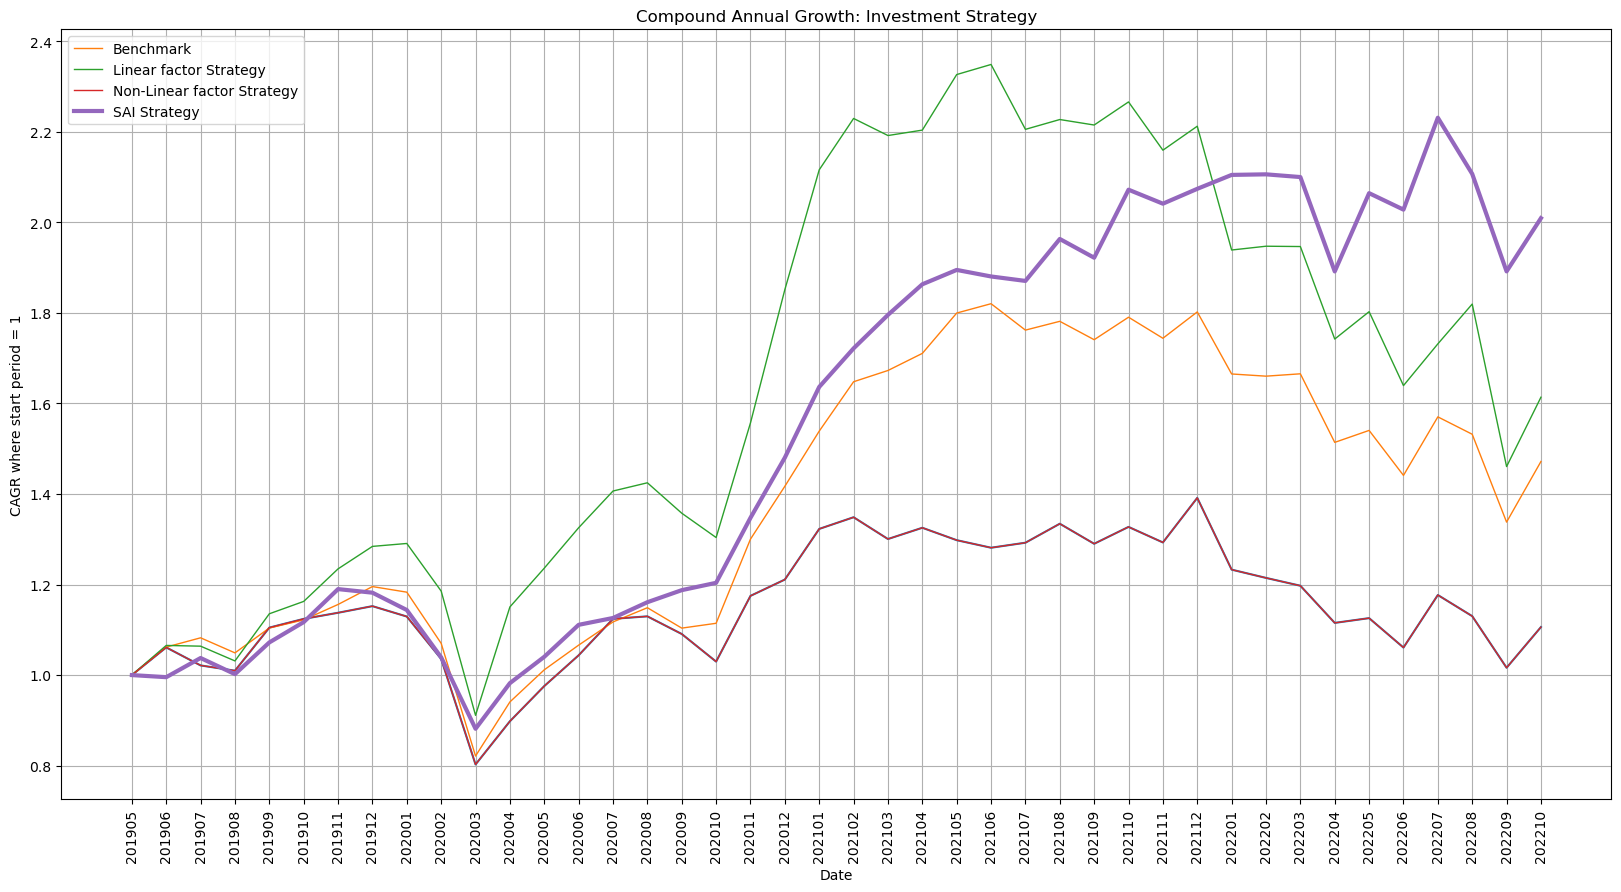

In [43]:
# Run the function to establish simple trades
df_sai_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_sai_all_er, rebalance_freq=6, min_quantile_to_buy=0.8)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_sai_trades)),
                 int(SimulationUtils.start_period_trades(df_trades)),
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_sai_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_trades, 
                         rebalance_freq=6, 
                         df_sec_rets=df_sec_rets,
                         print_chart=False,
                         date_start_of_sim=start_date)  

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_non_lin_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_sec_cagr.sum(axis=1, skipna=True), 'SAI Strategy', emphasize=True)
p.legend()
p.show()

### 3) c) iv) SAI Model: Judging model performance

We now compare our model performance vs the empirical distribution generated by the target shuffling lite approach.

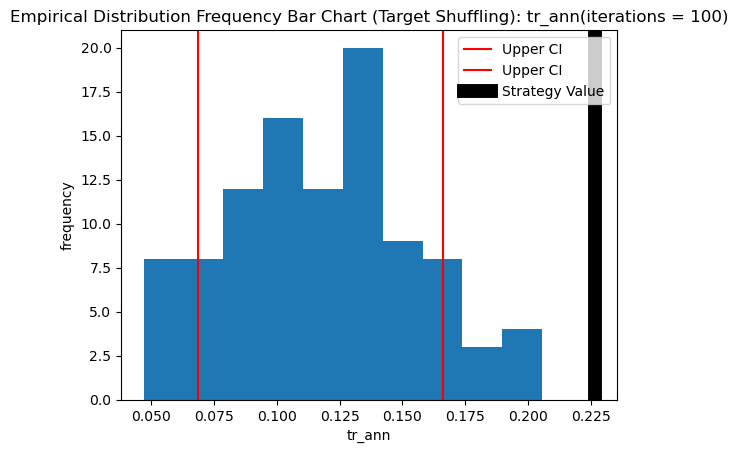

Empirical probability value of the strategy: tr_ann:1.0


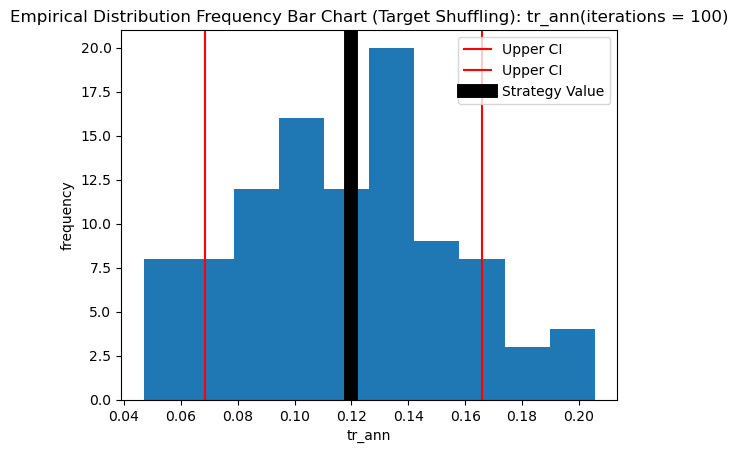

Empirical probability value of the strategy: tr_ann:0.53


In [44]:
# check the performance of the SAI simultation using target shuffling lite, to form an empirical distributon of returns
# Simulation
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_sai_sec_cagr)
# benchmark
RobustInvestmentUtils.target_shuffling_chart(dt_target_shuffling_dist, df_benchmark_sec_cagr)

## Bias Alert: End point bias

End point bias refers to the biased selection of a given time period and end date we might use to assess a model's performance. It is notable that each approach we have tested has certain periods where it appears to be the "best", and assessing performance to the last elapsed period is to some extent aritrary. We can deal with this to some extent by using different sub-time periods to assess model performance over, perhaps coinciding with different market conditions (analytics such as hit rate can also allow us to assess consistency of return delivery). We can also test our model out-of-sample, and in subsamples, such as in different countries and sectors to assess generalization.

## 3d) SAI Using Fundamental Data

Having compared the SAI output to linear and non linear factor models, we can now train the SAI model on more than just the factor loadings, adding our unaltered fundamental data to the training also. With fundamental inputs rather than factors, we can also increase the lift our rules need to achieve to be used.

In [45]:
# Get training and test data to pass into SAI 
sai_X, sai_y = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                  df_sec_rets=df_sec_rets,
                                  dic_fundamentals=dict_sec_ff, #<< Pass populated dict
                                  df_ff_factors=df_ff_factors,
                                  date_end=0,
                                  buysell_threshold_quantile=0.75,
                                  forecast_ahead=12,
                                  window_size=36,
                                  func_training_period=1)
display(sai_X)

,const,mkt-rf,smb,hml,rmw,cma,ff_net_mgn,ff_oper_mgn,ff_roa,ff_roe,ff_rotc,ff_tcap,ff_pbk
ticker,,,,,,,,,,,,,
WW-US,-0.000709,1.727208,-0.551075,1.155468,-0.509445,0.935243,5.447913,18.451968,5.039725,NaN,23.942814,1067.882000,NaN
WABC-US,-0.006226,0.733428,0.062583,-0.183539,-0.123613,0.827728,38.668090,49.657862,1.296760,10.203232,11.831237,966.186000,1.754430
VVR-US,0.004970,0.418818,0.112157,0.673099,0.028360,-0.781049,171.893031,198.582880,2.846446,4.783005,3.690296,1009.776957,0.911890
VSEC-US,0.011058,0.347552,2.383096,0.781128,1.621947,-1.625300,-0.781520,8.543676,-0.630202,-1.437551,8.727132,634.237000,1.194180
VCV-US,0.001365,0.282721,-0.006619,0.111647,-0.433755,-0.387174,9.640826,9.640826,0.414401,0.645781,0.418406,997.765908,0.957134
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATRI-US,-0.005811,-0.102934,0.393291,-0.513022,1.851607,1.085086,21.759457,24.166785,12.143590,13.428473,14.914115,240.442000,4.877390
APOG-US,-0.009598,0.640118,0.933473,0.774184,-0.185789,-1.597658,1.254170,6.059195,1.439865,3.058078,9.886991,719.435000,1.951700
AORT-US,0.006958,1.106851,0.873698,0.561735,-0.640760,-0.828907,-6.543931,1.003842,-2.375672,-5.394127,0.431969,646.087000,2.794520


In [46]:
# Run the function with ALL our data
# We now add our fundamental data dict to the training process, and extend the forecast term to 12m (as we are using annual accounts)
df_sai_all_features_all_er, sai_all_features_mod_latest = SAIInvesting.sai_forecast_all_er(df_benchmark_trades=df_benchmark_trades,
                                                    df_tb3ms=df_tb3ms, 
                                                    df_sec_rets=df_sec_rets,
                                                    dic_fundamentals=dict_sec_ff, #<< Pass populated dict
                                                    df_ff_factors=df_ff_factors,
                                                    date_end=0,
                                                    buysell_threshold_quantile=0.75,
                                                    lift_cut_off=1.5,
                                                    forecast_ahead=6,
                                                    window_size=36,
                                                    func_training_period=1)


0it [00:00, ?it/s]

In [50]:
df_sai_all_features_all_er

TICKER,WW-US,WABC-US,VVR-US,VSEC-US,VCV-US,URG-US,ULH-US,UEIC-US,TWO-US,TELL-US,...,ATRI-US,APYX-US,APOG-US,AORT-US,ALNY-US,ALIM-US,ALG-US,AGM-US,ACAD-US,AAON-US
DATE,,,,,,,,,,,,,,,,,,,,,
202210,NaN,1.715104,1.850000,1.755787,NaN,NaN,1.805952,1.885789,1.541667,1.541667,...,NaN,1.651786,NaN,1.541667,1.651786,1.693080,1.801058,1.761905,1.541667,1.761905
202209,1.508264,1.508264,NaN,2.398275,1.508264,NaN,NaN,1.842013,1.990909,1.736217,...,1.508264,1.901371,1.508264,1.781807,1.645279,2.152201,1.955357,NaN,1.736217,NaN
202208,NaN,NaN,NaN,NaN,NaN,2.105590,NaN,NaN,1.742236,1.639752,...,NaN,2.084161,1.760870,1.639752,1.639752,1.805901,1.739130,2.213251,1.639752,1.788820
202207,1.717963,NaN,1.920048,1.769794,1.521739,2.008696,1.521739,1.793478,NaN,1.673913,...,NaN,2.025302,1.907880,NaN,1.942754,1.814604,1.766908,2.216878,2.008696,1.807065
202206,1.593633,1.547511,1.586590,1.763778,1.547511,2.082017,1.547511,1.609412,1.547511,1.609412,...,1.547511,1.609412,1.841604,NaN,1.865142,1.724732,2.327807,1.947763,1.865142,1.693984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201603,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
201601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# Run the function to establish simple trades
df_sai_all_features_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_sai_all_features_all_er, rebalance_freq=6, min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_sai_all_features_trades)), 
                 int(SimulationUtils.start_period_trades(df_sai_trades)),
                 int(SimulationUtils.start_period_trades(df_trades)),#
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_sai_all_features_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_all_features_trades, 
                                        rebalance_freq=6, 
                                        df_sec_rets=df_sec_rets,
                                        print_chart=False,
                                        date_start_of_sim=start_date)  

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_sai_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_non_lin_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_sec_cagr.sum(axis=1, skipna=True), 'SAI Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_all_features_sec_cagr.sum(axis=1, skipna=True), 'SAI EXTENDED FEATURES lift=1.2 Strategy', emphasize=True)
p.legend()
p.show()

We can directly examine the rules driving the latest SAI model 

In [48]:
# Rules our model will be using, needing to show a reasonable "lift"
sai_all_features_mod_latest.rules[(sai_all_features_mod_latest.rules['causal_lift']>1.5)]

,rules,cond_success_prob,odd_ratio,causal_lift
169766,"(cma_3, smb_1, ff_tcap_2)",1.0,inf,3.083333
170348,"(ff_roe_2, rmw_1, smb_1, ff_tcap_2)",1.0,inf,3.083333
186274,"(rmw_2, ff_tcap_1, hml_2)",1.0,inf,3.083333
169626,"(mkt-rf_2, ff_tcap_2)",1.0,inf,3.083333
169656,"(mkt-rf_2, smb_1, ff_tcap_2)",1.0,inf,3.083333
...,...,...,...,...
172788,"(ff_oper_mgn_2, ff_roe_3, ff_roa_3)",0.5,2.368421,1.541667
182650,"(ff_roe_1, ff_roa_1, ff_net_mgn_1, rmw_1, mkt-...",0.5,2.300000,1.541667
172831,"(ff_net_mgn_2, ff_oper_mgn_2, ff_roe_3, ff_roa_3)",0.5,2.368421,1.541667
172730,"(ff_net_mgn_2, ff_oper_mgn_2, const_1)",0.5,2.300000,1.541667


## 3e) More Lift?

Now ask that the rules SAI learns exhibit greater lift... We crank up the lift requirement 


In [49]:
# Run the function with ALL our data
# We now add our fundamental data dict to the training process, and extend the forecast term to 12m (as we are using annual accounts)
df_sai_all_lift2_features_all_er, sai_all_lift2_features_mod_latest = SAIInvesting.sai_forecast_all_er(df_benchmark_trades=df_benchmark_trades,
                                                    df_tb3ms=df_tb3ms, 
                                                    df_sec_rets=df_sec_rets,
                                                    dic_fundamentals=dict_sec_ff, #<< Pass populated dict
                                                    df_ff_factors=df_ff_factors,
                                                    date_end=0,
                                                    buysell_threshold_quantile=0.75,
                                                    lift_cut_off=2.0, # << Increase the lift for the rules
                                                    forecast_ahead=6,
                                                    window_size=36,
                                                    func_training_period=1)

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Run the function to establish simple trades
df_sai_all_lift2_features_trades = SimulationUtils.trades_topquantile_generate(df_all_er=df_sai_all_features_all_er, rebalance_freq=6, min_quantile_to_buy=0.75)

# Get the min common start date for the simulations (given the different training data windows they might use) so as we can compare them
start_date = min(int(SimulationUtils.start_period_trades(df_sai_all_lift2_features_trades)), 
                 int(SimulationUtils.start_period_trades(df_sai_all_features_trades)), 
                 int(SimulationUtils.start_period_trades(df_sai_trades)),
                 int(SimulationUtils.start_period_trades(df_trades)),
                 int(SimulationUtils.start_period_trades(df_nlf_trades)),
                 int(SimulationUtils.start_period_trades(df_benchmark_trades)))

# Plot the non-linear-factor model CAGR vs the benchmark
df_sai_all_lift2_features_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_all_lift2_features_trades, 
                                        rebalance_freq=6, 
                                        df_sec_rets=df_sec_rets,
                                        print_chart=False,
                                        date_start_of_sim=start_date)  

# Run sims from the same start date.
print('Run simulations from a common start date...')
df_sai_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_sai_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_non_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_nlf_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_lin_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_lin_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  
df_benchmark_sec_cagr, p = SimulationUtils.run_sim(df_trades=df_benchmark_trades, rebalance_freq=6, df_sec_rets=df_sec_rets, print_chart=False, date_start_of_sim=start_date)  

# Chart
print('Generate charts...')
p = SimulationUtils.sim_chart(df_non_lin_sec_cagr)
SimulationUtils.sim_chart_add_series(p, df_benchmark_sec_cagr.sum(axis=1, skipna=True), 'Benchmark')
SimulationUtils.sim_chart_add_series(p, df_lin_sec_cagr.sum(axis=1, skipna=True), 'Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_non_lin_sec_cagr.sum(axis=1, skipna=True), 'Non-Linear factor Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_sec_cagr.sum(axis=1, skipna=True), 'SAI Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_all_features_sec_cagr.sum(axis=1, skipna=True), 'SAI EXTENDED FEATURES lift=1.2 Strategy')
SimulationUtils.sim_chart_add_series(p, df_sai_all_lift2_features_sec_cagr.sum(axis=1, skipna=True), 'SAI EXTENDED FEATURES lift=2 Strategy', emphasize=True)
p.legend()
p.show()

In [ ]:
# Rules our model will be using, needing to show a reasonable "lift"
sai_all_lift2_features_mod_latest.rules[(sai_all_lift2_features_mod_latest.rules['causal_lift']>2.00)]

## 3f) Superior Ground Truthing using SAI

A further feature of the SAI approach is to target multiple outcomes, also know as multi-task learning, where we can set the **ground truth** of our problem to multiple objectives and not just identifying superior returns as traditional quantitative models do. With multitask learning we can train an SAI model that aims to identify stocks that may generate superior returns **AND** superior US$ earnings, **AND** good down-side capture, and so on. As a result SAI can target more complex ground truths, to increase the chance stocks selected are "right for the right reasons". This is also likely to result in a more robust modelling outcome, owing to one set of model parameters needing to achieve multiple, hopefully compatible, and intuitively causal objectives.
This can be achieved by simply specifying SAI's y-variable with the multiple conditions required to support the ground truth. 


# Stage4: Model Deployment

As we have alrteady seen with the Credit Use Case, model deployment requires 

Investment model deployment requires a rigorous change process, several levels of testing and sign off, asignment of responsibilities for the live operation of the process, models and data before deployiong the code to the cloud (or on native hardware). 
A key part of this stage is monitoring of data drift, and the monitoring of stakeholder KPIs which are principally for investors, and compliance needs.
For investors, the characteristics of the strategy that were marketed and agreed with the investor, should be monitored and reported regularly with sufficient executive oversight and repotring to support it.
For Compliance, regular checking that the investment elements of the strategy are fully compliant with the investment management agreement (IMA), which organisations will tend to have in place as a separate system in any case. 


# Stage 5: Model Monitoring and Reporting

##Stage5a: Data Drift

Our model is now in production and being used in practice. We need to monitor its stability. One approach is to monitor the distribution of the input data versus the data the model was trained with . If the distributions have shifted the model outcomes could be invalidated. Here we use our function data_drift_psi to monitor data drift.

Is it time for us to retrain our model?

In [ ]:
# Get Data
#================================  
sai_train_X, sai_train_y = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                df_sec_rets=df_sec_rets,
                                dic_fundamentals=dict_sec_ff,
                                df_ff_factors=df_ff_factors,
                                date_end=0,  #<< Latest period
                                func_training_period=6,
                                buysell_threshold_quantile=0.75,
                                forecast_ahead=6, #<< Latest period
                                window_size=36) #<< Latest period

sai_test_X, sai_test_y = SAIInvesting.sai_er_func_prep_data(df_tb3ms=df_tb3ms, 
                                df_sec_rets=df_sec_rets,
                                dic_fundamentals=dict_sec_ff,
                                df_ff_factors=df_ff_factors,
                                date_end=1,  #<< Latest period
                                func_training_period=1,
                                buysell_threshold_quantile=0.75,
                                forecast_ahead=0, #<< Latest period
                                window_size=36) #<< Latest period


# The test data may not contain all the columns in the train data. 
# we can add nan columns for the missing columns....
# Add blank column if a column exists in the training data and NOT in the test
missing_cols_to_add = [col for col in sai_test_X.columns if col not in sai_train_X.columns]
sai_train_X[[missing_cols_to_add]] = np.nan
missing_cols_to_add = [col for col in sai_train_X.columns if col not in sai_test_X.columns]
sai_test_X[[missing_cols_to_add]] = np.nan

# Prepare train and test data for data drift check
train_datadrift = sai_train_X # pd.concat([sai_train_X, sai_train_y], axis=1)
test_datadrift = sai_test_X # pd.concat([sai_test_X, sai_test_y], axis=1)

# Data drift check...
data_drift_features = GovernanceUtils.data_drift_psi(train_datadrift, test_datadrift, buckettype='bins',buckets=10,axis=1,single_variable=False)
data_drift_target = data_drift_features[-1]

# Print out the target PSI value:
print("Target PSI value is ",data_drift_target, "\n" )


## Stage5b: Challenger Models

We have tested three types of stock selecion model in this notebook. We have selected the SAI approach, but we could still use the other models to provide another check on our live model, ie a **challenger model**.


# Afterword

We have done our best to include the key themes of what we think are the critical stages of model development in this notebook, but clearly in practice many more checks and details would be added to each of the 5 model development stages to best ensure stakeholder's KPIs are met, and Governance standards would be as high as possible. Hopefully our example and key themes will provide insight to avoid many of the classic biases in model development.